In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/UROLOGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=179.2, y1=102.1
Page 1, Q1, A: Yellow pixels: 162
Page 1, Q1, A: Total non-white pixels: 668
Page 1, Q1, A: Yellow percentage: 24.3%


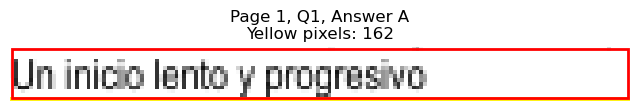

Page 1, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=268.4, y1=114.7
Page 1, Q1, B: Yellow pixels: 2496
Page 1, Q1, B: Total non-white pixels: 3263
Page 1, Q1, B: Yellow percentage: 76.5%


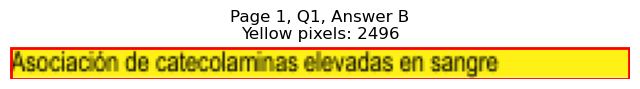

Page 1, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=409.3, y1=127.3
Page 1, Q1, C: Yellow pixels: 390
Page 1, Q1, C: Total non-white pixels: 2070
Page 1, Q1, C: Yellow percentage: 18.8%


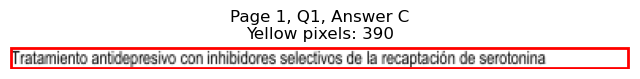

Page 1, Q1 - D: Detected box: x0=68.8, y0=127.2, x1=222.3, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 753
Page 1, Q1, D: Yellow percentage: 0.0%


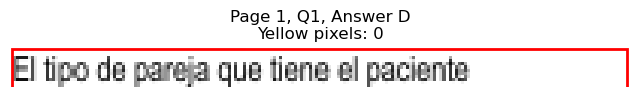


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=208.1, y1=190.4
Page 1, Q2, A: Yellow pixels: 191
Page 1, Q2, A: Total non-white pixels: 918
Page 1, Q2, A: Yellow percentage: 20.8%


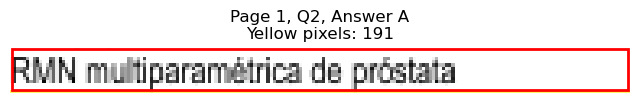

Page 1, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=201.8, y1=203.0
Page 1, Q2, B: Yellow pixels: 1844
Page 1, Q2, B: Total non-white pixels: 2392
Page 1, Q2, B: Yellow percentage: 77.1%


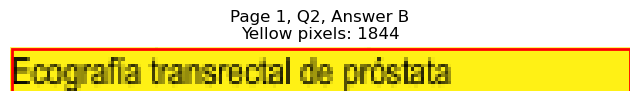

Page 1, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=380.2, y1=190.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 250
Page 1, Q2, C: Yellow percentage: 0.0%


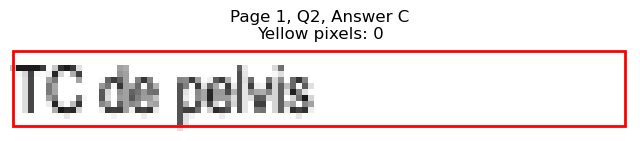

Page 1, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=480.6, y1=203.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 792
Page 1, Q2, D: Yellow percentage: 0.0%


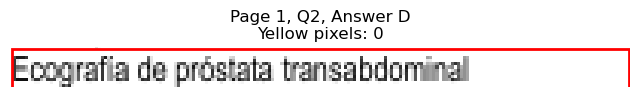


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=186.6, y1=253.5
Page 1, Q3, A: Yellow pixels: 1752
Page 1, Q3, A: Total non-white pixels: 2366
Page 1, Q3, A: Yellow percentage: 74.0%


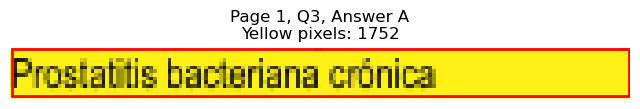

Page 1, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=89.4, y1=266.1
Page 1, Q3, B: Yellow pixels: 72
Page 1, Q3, B: Total non-white pixels: 180
Page 1, Q3, B: Yellow percentage: 40.0%


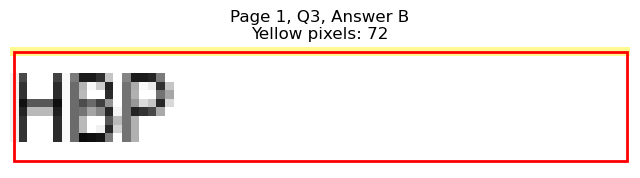

Page 1, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=398.2, y1=253.5
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 366
Page 1, Q3, C: Yellow percentage: 0.0%


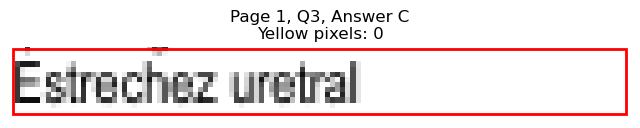

Page 1, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=409.3, y1=266.1
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 398
Page 1, Q3, D: Yellow percentage: 0.0%


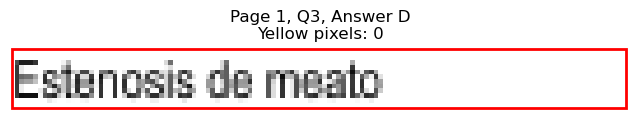


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=118.0, y1=316.7
Page 1, Q4, A: Yellow pixels: 1115
Page 1, Q4, A: Total non-white pixels: 1300
Page 1, Q4, A: Yellow percentage: 85.8%


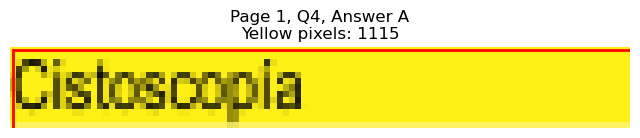

Page 1, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=116.9, y1=329.3
Page 1, Q4, B: Yellow pixels: 99
Page 1, Q4, B: Total non-white pixels: 336
Page 1, Q4, B: Yellow percentage: 29.5%


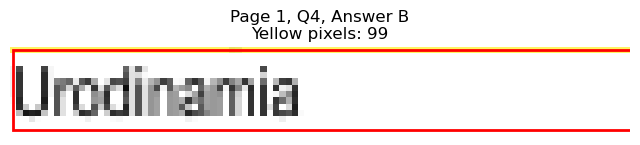

Page 1, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=447.9, y1=316.7
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 616
Page 1, Q4, C: Yellow percentage: 0.0%


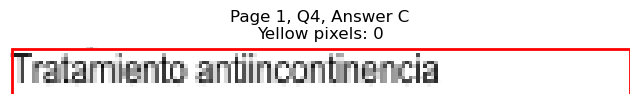

Page 1, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=383.7, y1=329.3
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 284
Page 1, Q4, D: Yellow percentage: 0.0%


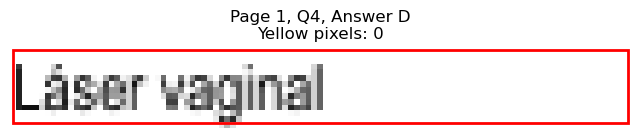


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=183.1, y1=405.0
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 622
Page 1, Q5, A: Yellow percentage: 0.0%


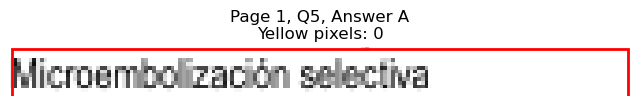

Page 1, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=174.6, y1=417.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 537
Page 1, Q5, B: Yellow percentage: 0.0%


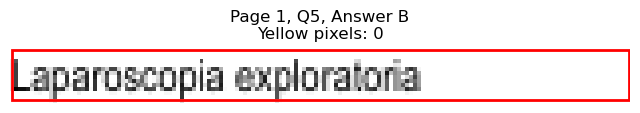

Page 1, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=380.2, y1=405.0
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 328
Page 1, Q5, C: Yellow percentage: 0.0%


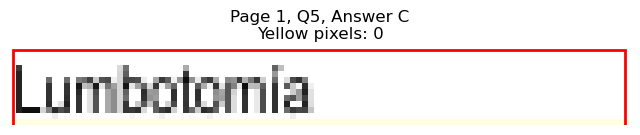

Page 1, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=394.7, y1=417.6
Page 1, Q5, D: Yellow pixels: 1290
Page 1, Q5, D: Total non-white pixels: 1652
Page 1, Q5, D: Yellow percentage: 78.1%


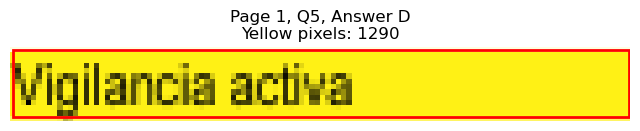


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=153.6, y1=468.1
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 448
Page 1, Q6, A: Yellow percentage: 0.0%


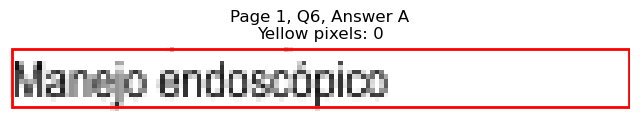

Page 1, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=141.5, y1=480.7
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 381
Page 1, Q6, B: Yellow percentage: 0.0%


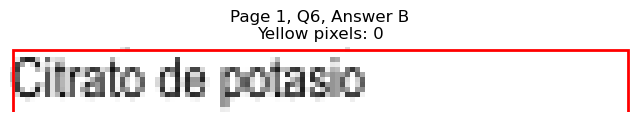

Page 1, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=479.1, y1=468.1
Page 1, Q6, C: Yellow pixels: 2036
Page 1, Q6, C: Total non-white pixels: 2842
Page 1, Q6, C: Yellow percentage: 71.6%


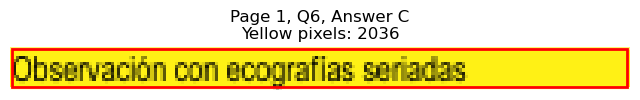

Page 1, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=474.6, y1=480.7
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 955
Page 1, Q6, D: Yellow percentage: 0.0%


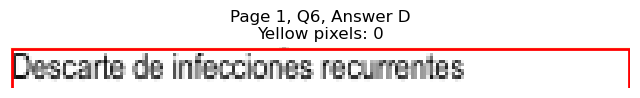


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=88.8, y1=518.6
Page 1, Q7, A: Yellow pixels: 853
Page 1, Q7, A: Total non-white pixels: 994
Page 1, Q7, A: Yellow percentage: 85.8%


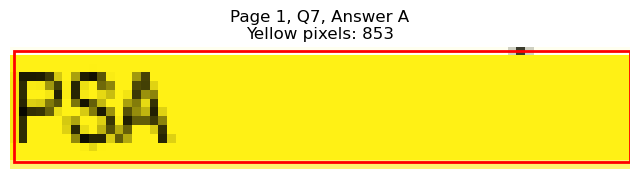

Page 1, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=139.0, y1=531.2
Page 1, Q7, B: Yellow pixels: 121
Page 1, Q7, B: Total non-white pixels: 504
Page 1, Q7, B: Yellow percentage: 24.0%


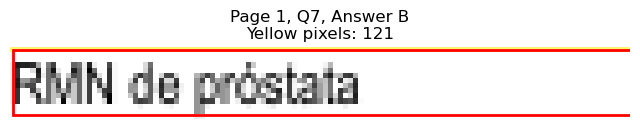

Page 1, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=388.7, y1=518.6
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 282
Page 1, Q7, C: Yellow percentage: 0.0%


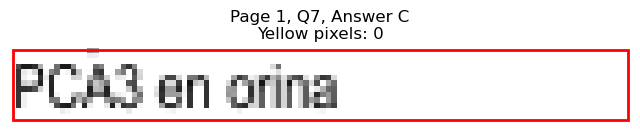

Page 1, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=402.8, y1=531.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 395
Page 1, Q7, D: Yellow percentage: 0.0%


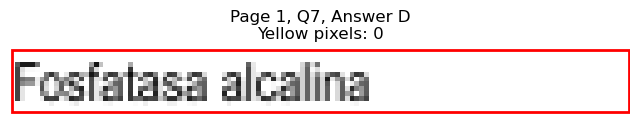


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=88.9, y1=569.2
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 64
Page 1, Q8, A: Yellow percentage: 0.0%


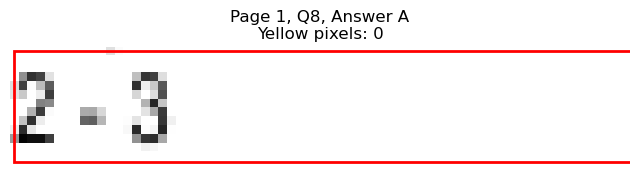

Page 1, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=94.0, y1=581.8
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 82
Page 1, Q8, B: Yellow percentage: 0.0%


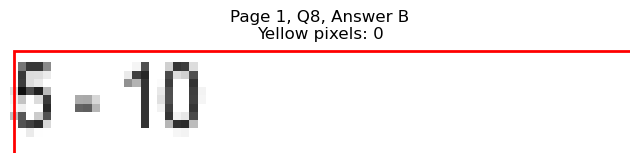

Page 1, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=347.9, y1=569.2
Page 1, Q8, C: Yellow pixels: 71
Page 1, Q8, C: Total non-white pixels: 141
Page 1, Q8, C: Yellow percentage: 50.4%


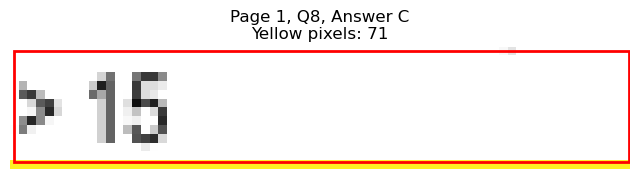

Page 1, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=342.9, y1=581.8
Page 1, Q8, D: Yellow pixels: 827
Page 1, Q8, D: Total non-white pixels: 858
Page 1, Q8, D: Yellow percentage: 96.4%


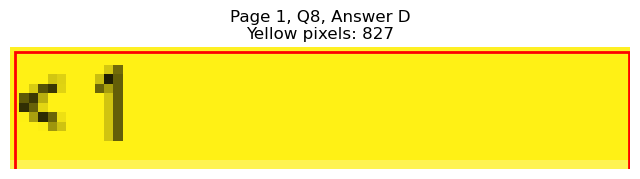


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=606.9, x1=126.5, y1=619.6
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 276
Page 1, Q9, A: Yellow percentage: 0.0%


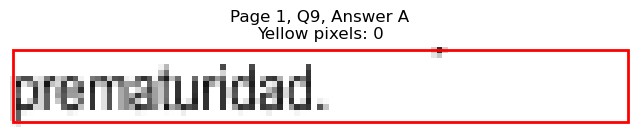

Page 1, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=157.1, y1=632.3
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 465
Page 1, Q9, B: Yellow percentage: 0.0%


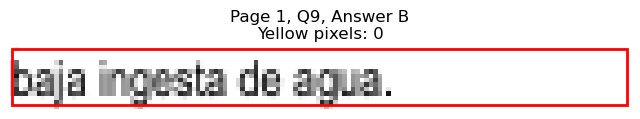

Page 1, Q9 - C: Detected box: x0=327.5, y0=606.9, x1=360.7, y1=619.6
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 165
Page 1, Q9, C: Yellow percentage: 0.0%


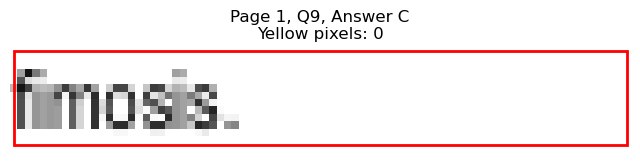

Page 1, Q9 - D: Detected box: x0=327.5, y0=619.6, x1=455.9, y1=632.3
Page 1, Q9, D: Yellow pixels: 1666
Page 1, Q9, D: Total non-white pixels: 2506
Page 1, Q9, D: Yellow percentage: 66.5%


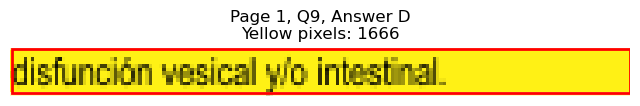


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=657.5, x1=137.1, y1=670.1
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 343
Page 1, Q10, A: Yellow percentage: 0.0%


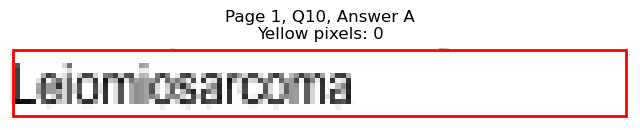

Page 1, Q10 - B: Detected box: x0=68.3, y0=670.1, x1=139.0, y1=682.7
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 360
Page 1, Q10, B: Yellow percentage: 0.0%


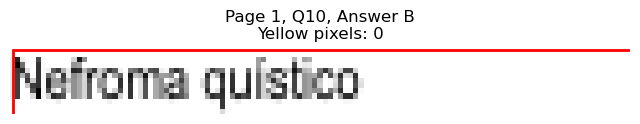

Page 1, Q10 - C: Detected box: x0=327.5, y0=657.5, x1=448.9, y1=670.1
Page 1, Q10, C: Yellow pixels: 1795
Page 1, Q10, C: Total non-white pixels: 2408
Page 1, Q10, C: Yellow percentage: 74.5%


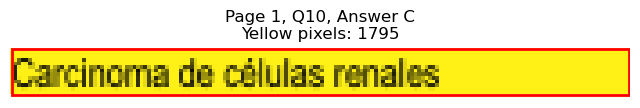

Page 1, Q10 - D: Detected box: x0=327.5, y0=670.1, x1=464.9, y1=682.7
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 865
Page 1, Q10, D: Yellow percentage: 0.0%


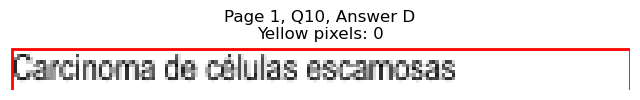


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=68.3, y0=240.9, x1=110.5, y1=253.5
Page 1, Q11, A: Yellow pixels: 851
Page 1, Q11, A: Total non-white pixels: 1302
Page 1, Q11, A: Yellow percentage: 65.4%


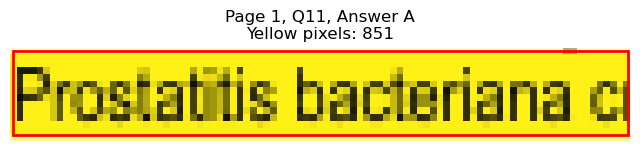

Page 1, Q11 - B: Detected box: x0=68.3, y0=720.6, x1=142.6, y1=733.2
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 379
Page 1, Q11, B: Yellow percentage: 0.0%


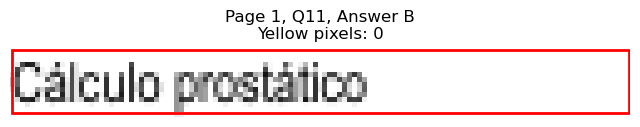

Page 1, Q11 - C: Detected box: x0=327.5, y0=708.0, x1=397.7, y1=720.6
Page 1, Q11, C: Yellow pixels: 121
Page 1, Q11, C: Total non-white pixels: 485
Page 1, Q11, C: Yellow percentage: 24.9%


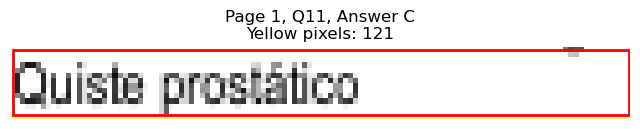

Page 1, Q11 - D: Detected box: x0=327.5, y0=720.6, x1=442.9, y1=733.2
Page 1, Q11, D: Yellow pixels: 1715
Page 1, Q11, D: Total non-white pixels: 2324
Page 1, Q11, D: Yellow percentage: 73.8%


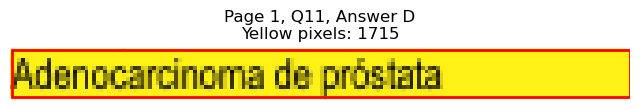


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 12 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=124.9, y1=114.7
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 358
Page 2, Q1, A: Yellow percentage: 0.0%


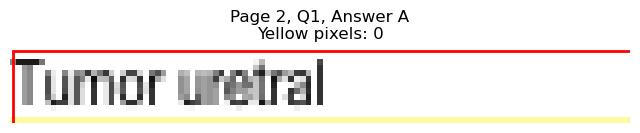

Page 2, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=128.5, y1=127.3
Page 2, Q1, B: Yellow pixels: 1093
Page 2, Q1, B: Total non-white pixels: 1554
Page 2, Q1, B: Yellow percentage: 70.3%


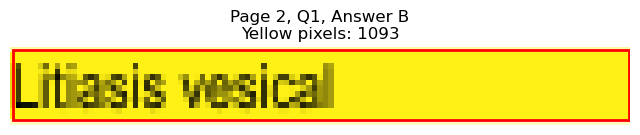

Page 2, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=399.8, y1=114.7
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 352
Page 2, Q1, C: Yellow percentage: 0.0%


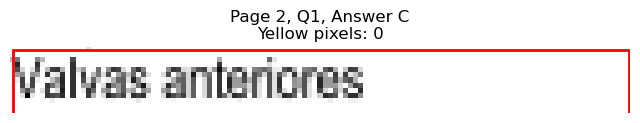

Page 2, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=397.3, y1=127.3
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 363
Page 2, Q1, D: Yellow percentage: 0.0%


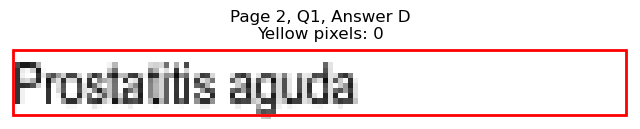


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=109.9, y1=165.2
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 221
Page 2, Q2, A: Yellow percentage: 0.0%


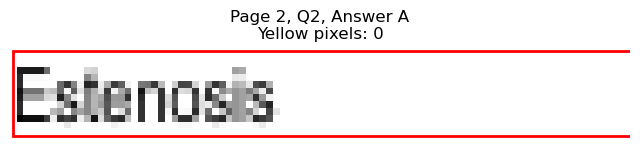

Page 2, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=116.9, y1=177.8
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 235
Page 2, Q2, B: Yellow percentage: 0.0%


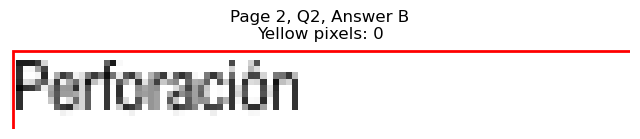

Page 2, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=364.1, y1=165.2
Page 2, Q2, C: Yellow pixels: 1001
Page 2, Q2, C: Total non-white pixels: 1232
Page 2, Q2, C: Yellow percentage: 81.2%


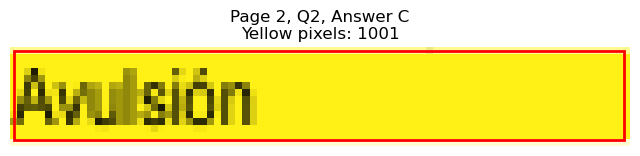

Page 2, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=441.4, y1=177.8
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 734
Page 2, Q2, D: Yellow percentage: 0.0%


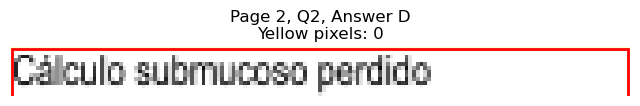


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=202.9, x1=122.9, y1=215.6
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 274
Page 2, Q3, A: Yellow percentage: 0.0%


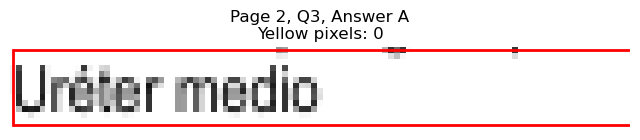

Page 2, Q3 - B: Detected box: x0=68.3, y0=215.7, x1=146.5, y1=228.3
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 386
Page 2, Q3, B: Yellow percentage: 0.0%


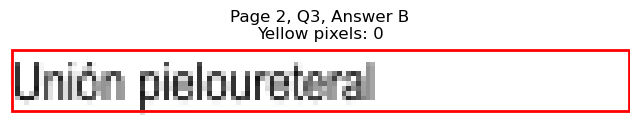

Page 2, Q3 - C: Detected box: x0=327.5, y0=202.9, x1=412.3, y1=215.6
Page 2, Q3, C: Yellow pixels: 1422
Page 2, Q3, C: Total non-white pixels: 1904
Page 2, Q3, C: Yellow percentage: 74.7%


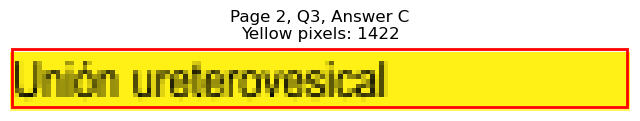

Page 2, Q3 - D: Detected box: x0=327.5, y0=215.7, x1=486.0, y1=228.3
Page 2, Q3, D: Yellow pixels: 209
Page 2, Q3, D: Total non-white pixels: 983
Page 2, Q3, D: Yellow percentage: 21.3%


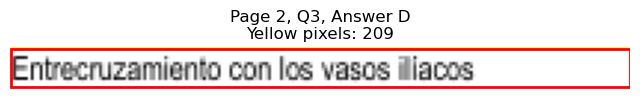


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=253.5, x1=121.5, y1=266.1
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 250
Page 2, Q4, A: Yellow percentage: 0.0%


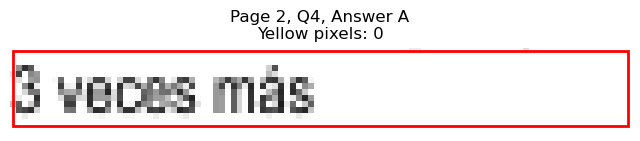

Page 2, Q4 - B: Detected box: x0=68.3, y0=266.1, x1=121.6, y1=278.7
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 243
Page 2, Q4, B: Yellow percentage: 0.0%


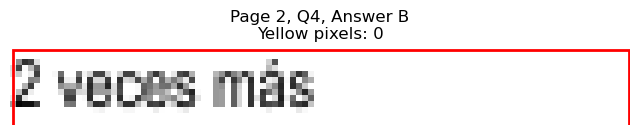

Page 2, Q4 - C: Detected box: x0=327.5, y0=253.5, x1=395.8, y1=266.1
Page 2, Q4, C: Yellow pixels: 1307
Page 2, Q4, C: Total non-white pixels: 1666
Page 2, Q4, C: Yellow percentage: 78.5%


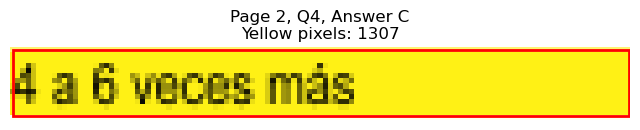

Page 2, Q4 - D: Detected box: x0=327.5, y0=266.1, x1=367.7, y1=278.7
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 285
Page 2, Q4, D: Yellow percentage: 0.0%


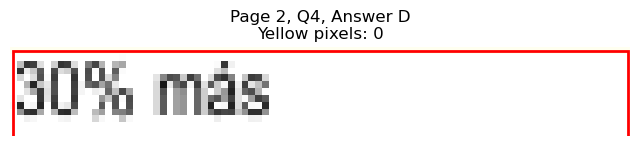


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=205.7, y1=329.3
Page 2, Q5, A: Yellow pixels: 188
Page 2, Q5, A: Total non-white pixels: 805
Page 2, Q5, A: Yellow percentage: 23.4%


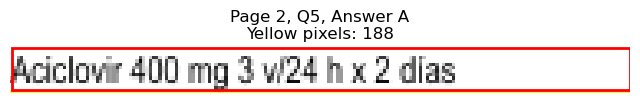

Page 2, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=203.2, y1=341.9
Page 2, Q5, B: Yellow pixels: 1947
Page 2, Q5, B: Total non-white pixels: 2418
Page 2, Q5, B: Yellow percentage: 80.5%


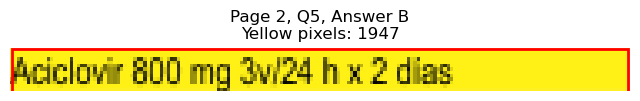

Page 2, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=457.0, y1=329.3
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 590
Page 2, Q5, C: Yellow percentage: 0.0%


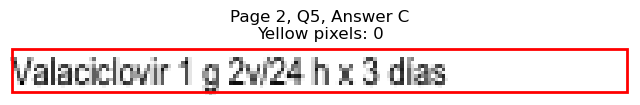

Page 2, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=457.0, y1=341.9
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 582
Page 2, Q5, D: Yellow percentage: 0.0%


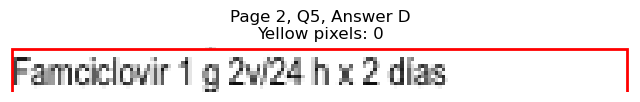


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=367.1, x1=269.9, y1=379.8
Page 2, Q6, A: Yellow pixels: 2
Page 2, Q6, A: Total non-white pixels: 1212
Page 2, Q6, A: Yellow percentage: 0.2%


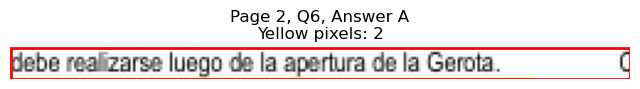

Page 2, Q6 - B: Detected box: x0=68.3, y0=379.7, x1=213.3, y1=392.4
Page 2, Q6, B: Yellow pixels: 1780
Page 2, Q6, B: Total non-white pixels: 2744
Page 2, Q6, B: Yellow percentage: 64.9%


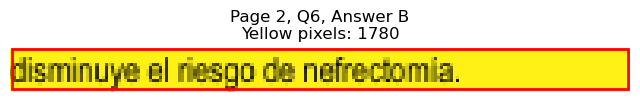

Page 2, Q6 - C: Detected box: x0=327.5, y0=367.1, x1=497.0, y1=379.8
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 862
Page 2, Q6, C: Yellow percentage: 0.0%


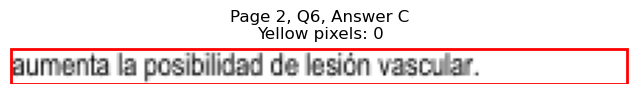

Page 2, Q6 - D: Detected box: x0=327.5, y0=379.7, x1=476.0, y1=392.4
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 710
Page 2, Q6, D: Yellow percentage: 0.0%


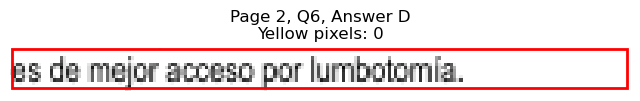


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=417.6, x1=187.5, y1=430.3
Page 2, Q7, A: Yellow pixels: 1596
Page 2, Q7, A: Total non-white pixels: 2380
Page 2, Q7, A: Yellow percentage: 67.1%


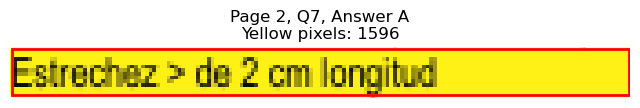

Page 2, Q7 - B: Detected box: x0=68.3, y0=430.2, x1=192.7, y1=442.9
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 752
Page 2, Q7, B: Yellow percentage: 0.0%


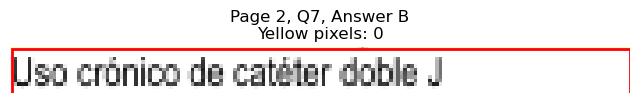

Page 2, Q7 - C: Detected box: x0=327.5, y0=417.6, x1=537.2, y1=430.3
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 1084
Page 2, Q7, C: Yellow percentage: 0.0%


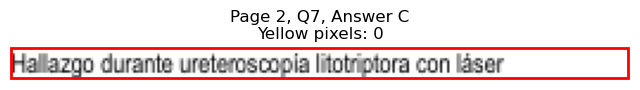

Page 2, Q7 - D: Detected box: x0=327.5, y0=430.2, x1=427.4, y1=442.9
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 532
Page 2, Q7, D: Yellow percentage: 0.0%


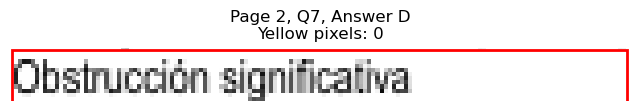


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=468.1, x1=124.9, y1=480.7
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 296
Page 2, Q8, A: Yellow percentage: 0.0%


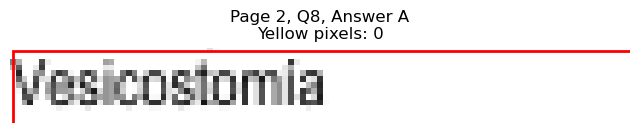

Page 2, Q8 - B: Detected box: x0=68.3, y0=480.8, x1=195.3, y1=493.4
Page 2, Q8, B: Yellow pixels: 1634
Page 2, Q8, B: Total non-white pixels: 2492
Page 2, Q8, B: Yellow percentage: 65.6%


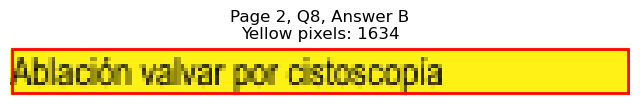

Page 2, Q8 - C: Detected box: x0=327.5, y0=468.1, x1=496.5, y1=480.7
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 855
Page 2, Q8, C: Yellow percentage: 0.0%


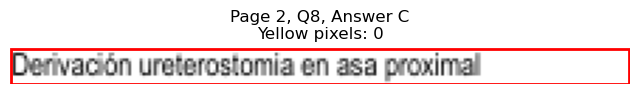

Page 2, Q8 - D: Detected box: x0=327.5, y0=480.8, x1=413.3, y1=493.4
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 441
Page 2, Q8, D: Yellow percentage: 0.0%


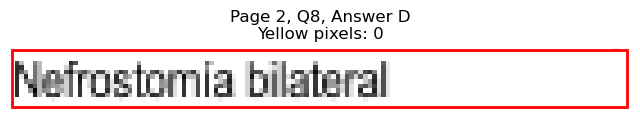


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=531.2, x1=124.5, y1=543.8
Page 2, Q9, A: Yellow pixels: 1180
Page 2, Q9, A: Total non-white pixels: 1391
Page 2, Q9, A: Yellow percentage: 84.8%


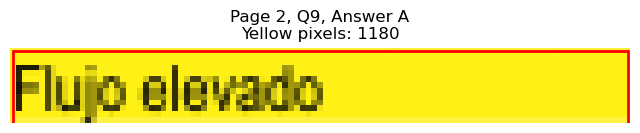

Page 2, Q9 - B: Detected box: x0=68.3, y0=543.8, x1=107.9, y1=556.4
Page 2, Q9, B: Yellow pixels: 87
Page 2, Q9, B: Total non-white pixels: 292
Page 2, Q9, B: Yellow percentage: 29.8%


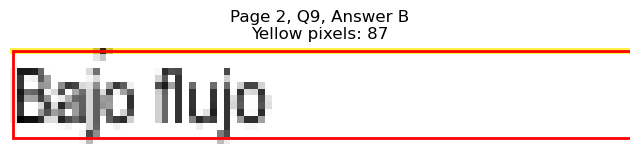

Page 2, Q9 - C: Detected box: x0=327.5, y0=531.2, x1=374.7, y1=543.8
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 234
Page 2, Q9, C: Yellow percentage: 0.0%


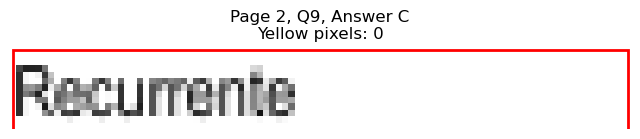

Page 2, Q9 - D: Detected box: x0=327.5, y0=543.8, x1=371.2, y1=556.4
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 221
Page 2, Q9, D: Yellow percentage: 0.0%


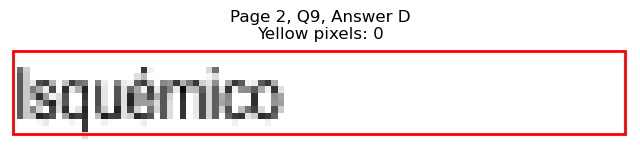


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=581.7, x1=232.2, y1=594.4
Page 2, Q10, A: Yellow pixels: 213
Page 2, Q10, A: Total non-white pixels: 1017
Page 2, Q10, A: Yellow percentage: 20.9%


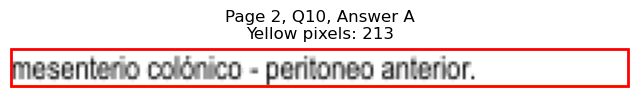

Page 2, Q10 - B: Detected box: x0=68.3, y0=594.3, x1=236.8, y1=607.0
Page 2, Q10, B: Yellow pixels: 2127
Page 2, Q10, B: Total non-white pixels: 2782
Page 2, Q10, B: Yellow percentage: 76.5%


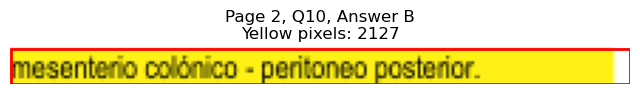

Page 2, Q10 - C: Detected box: x0=327.5, y0=581.7, x1=491.0, y1=594.4
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 823
Page 2, Q10, C: Yellow percentage: 0.0%


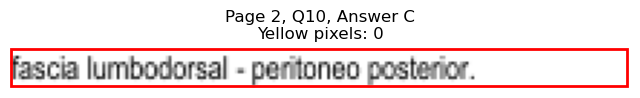

Page 2, Q10 - D: Detected box: x0=327.5, y0=594.3, x1=486.6, y1=607.0
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 783
Page 2, Q10, D: Yellow percentage: 0.0%


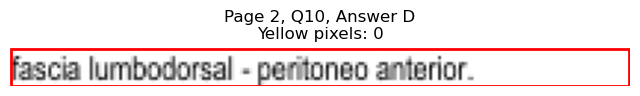


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)




Page 2, Q11 - A: Detected box: x0=68.3, y0=644.9, x1=177.1, y1=657.5
Page 2, Q11, A: Yellow pixels: 0
Page 2, Q11, A: Total non-white pixels: 568
Page 2, Q11, A: Yellow percentage: 0.0%


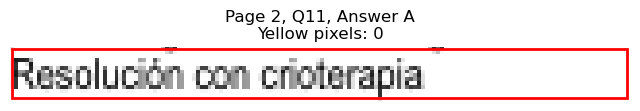

Page 2, Q11 - B: Detected box: x0=68.3, y0=657.5, x1=128.5, y1=670.1
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 292
Page 2, Q11, B: Yellow percentage: 0.0%


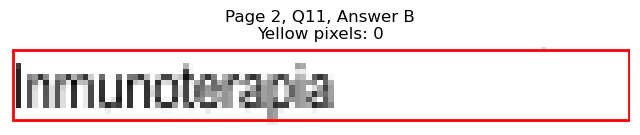

Page 2, Q11 - C: Detected box: x0=327.5, y0=644.9, x1=413.8, y1=657.5
Page 2, Q11, C: Yellow pixels: 137
Page 2, Q11, C: Total non-white pixels: 572
Page 2, Q11, C: Yellow percentage: 24.0%


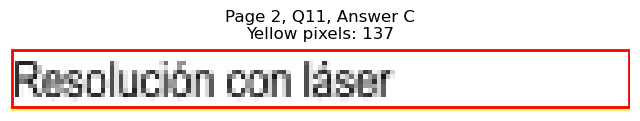

Page 2, Q11 - D: Detected box: x0=327.5, y0=657.5, x1=491.6, y1=670.1
Page 2, Q11, D: Yellow pixels: 2171
Page 2, Q11, D: Total non-white pixels: 2995
Page 2, Q11, D: Yellow percentage: 72.5%


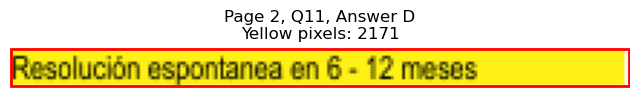


Page 2, Q11 - Selected Answer: D (based on yellow pixel count)




Page 2, Q12 - A: Detected box: x0=68.3, y0=695.4, x1=168.1, y1=708.0
Page 2, Q12, A: Yellow pixels: 0
Page 2, Q12, A: Total non-white pixels: 485
Page 2, Q12, A: Yellow percentage: 0.0%


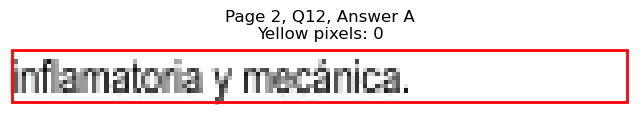

Page 2, Q12 - B: Detected box: x0=68.3, y0=708.0, x1=167.7, y1=720.6
Page 2, Q12, B: Yellow pixels: 0
Page 2, Q12, B: Total non-white pixels: 455
Page 2, Q12, B: Yellow percentage: 0.0%


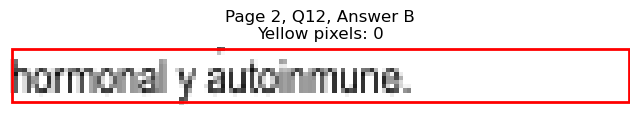

Page 2, Q12 - C: Detected box: x0=327.5, y0=695.4, x1=418.3, y1=708.0
Page 2, Q12, C: Yellow pixels: 1533
Page 2, Q12, C: Total non-white pixels: 1848
Page 2, Q12, C: Yellow percentage: 83.0%


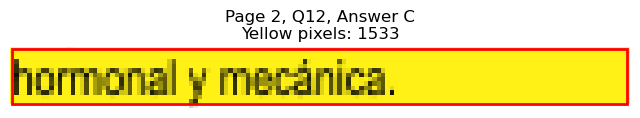

Page 2, Q12 - D: Detected box: x0=327.5, y0=708.0, x1=429.8, y1=720.6
Page 2, Q12, D: Yellow pixels: 151
Page 2, Q12, D: Total non-white pixels: 660
Page 2, Q12, D: Yellow percentage: 22.9%


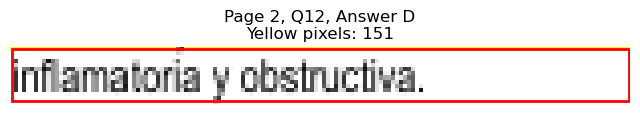


Page 2, Q12 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=170.1, y1=127.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 530
Page 3, Q1, A: Yellow percentage: 0.0%


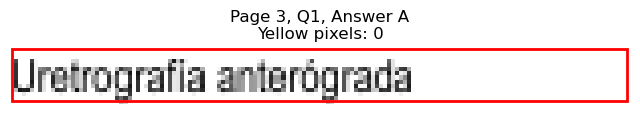

Page 3, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=144.0, y1=139.9
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 380
Page 3, Q1, B: Yellow percentage: 0.0%


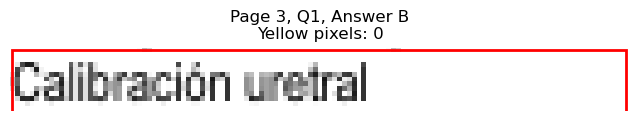

Page 3, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=471.0, y1=127.3
Page 3, Q1, C: Yellow pixels: 194
Page 3, Q1, C: Total non-white pixels: 868
Page 3, Q1, C: Yellow percentage: 22.4%


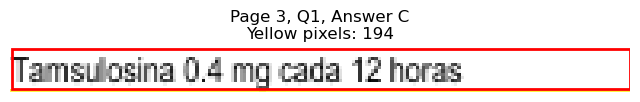

Page 3, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=377.2, y1=139.9
Page 3, Q1, D: Yellow pixels: 1119
Page 3, Q1, D: Total non-white pixels: 1313
Page 3, Q1, D: Yellow percentage: 85.2%


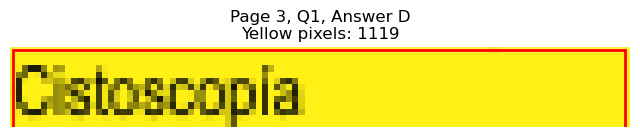


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=179.7, y1=177.8
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 533
Page 3, Q2, A: Yellow percentage: 0.0%


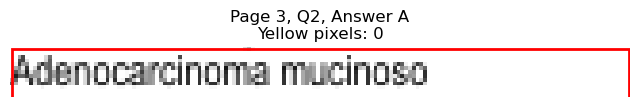

Page 3, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=146.7, y1=190.4
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 402
Page 3, Q2, B: Yellow percentage: 0.0%


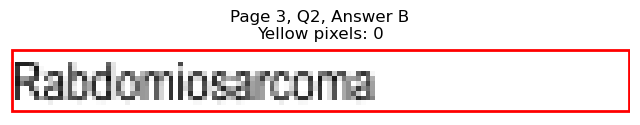

Page 3, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=458.9, y1=177.8
Page 3, Q2, C: Yellow pixels: 1847
Page 3, Q2, C: Total non-white pixels: 2366
Page 3, Q2, C: Yellow percentage: 78.1%


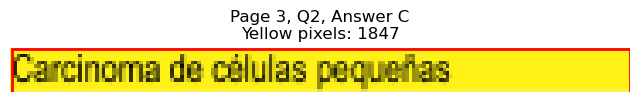

Page 3, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=366.2, y1=190.4
Page 3, Q2, D: Yellow pixels: 90
Page 3, Q2, D: Total non-white pixels: 278
Page 3, Q2, D: Yellow percentage: 32.4%


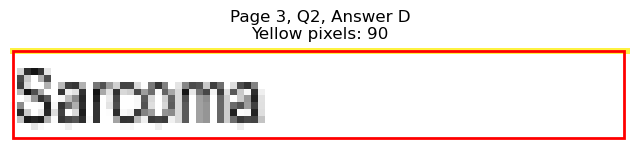


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=149.5, y1=228.3
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 399
Page 3, Q3, A: Yellow percentage: 0.0%


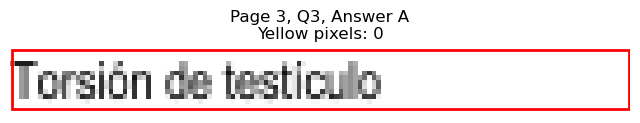

Page 3, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=116.4, y1=240.9
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 254
Page 3, Q3, B: Yellow percentage: 0.0%


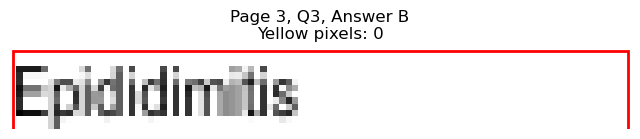

Page 3, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=368.2, y1=228.3
Page 3, Q3, C: Yellow pixels: 92
Page 3, Q3, C: Total non-white pixels: 315
Page 3, Q3, C: Yellow percentage: 29.2%


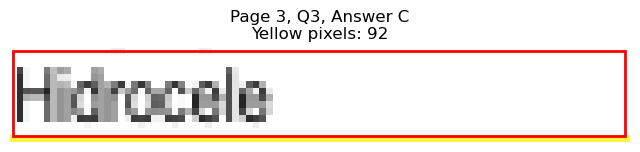

Page 3, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=430.4, y1=240.9
Page 3, Q3, D: Yellow pixels: 1631
Page 3, Q3, D: Total non-white pixels: 2002
Page 3, Q3, D: Yellow percentage: 81.5%


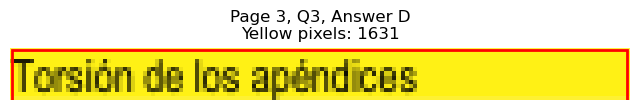


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=88.8, y1=278.7
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 94
Page 3, Q4, A: Yellow percentage: 0.0%


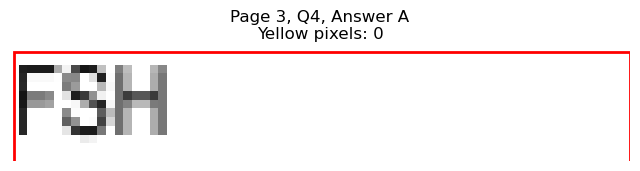

Page 3, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=82.3, y1=291.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 57
Page 3, Q4, B: Yellow percentage: 0.0%


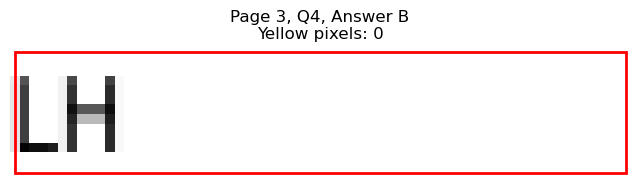

Page 3, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=382.7, y1=278.7
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 286
Page 3, Q4, C: Yellow percentage: 0.0%


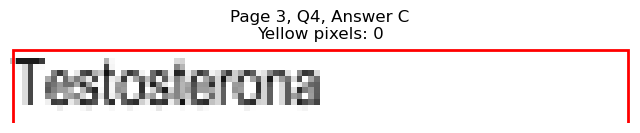

Page 3, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=355.1, y1=291.5
Page 3, Q4, D: Yellow pixels: 919
Page 3, Q4, D: Total non-white pixels: 1106
Page 3, Q4, D: Yellow percentage: 83.1%


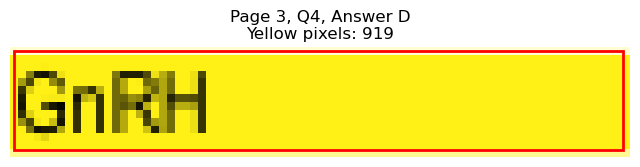


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=185.7, y1=341.9
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 590
Page 3, Q5, A: Yellow percentage: 0.0%


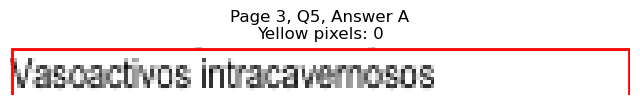

Page 3, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=157.1, y1=354.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 428
Page 3, Q5, B: Yellow percentage: 0.0%


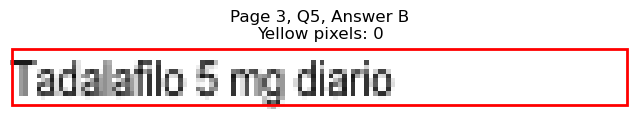

Page 3, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=400.3, y1=341.9
Page 3, Q5, C: Yellow pixels: 1343
Page 3, Q5, C: Total non-white pixels: 1612
Page 3, Q5, C: Yellow percentage: 83.3%


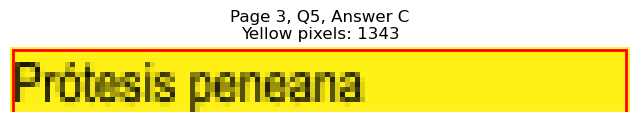

Page 3, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=410.8, y1=354.6
Page 3, Q5, D: Yellow pixels: 133
Page 3, Q5, D: Total non-white pixels: 556
Page 3, Q5, D: Yellow percentage: 23.9%


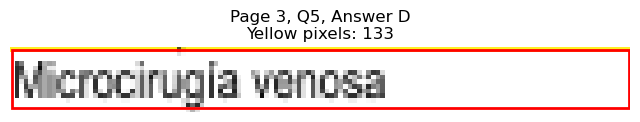


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=392.3, x1=214.8, y1=405.0
Page 3, Q6, A: Yellow pixels: 1968
Page 3, Q6, A: Total non-white pixels: 2561
Page 3, Q6, A: Yellow percentage: 76.8%


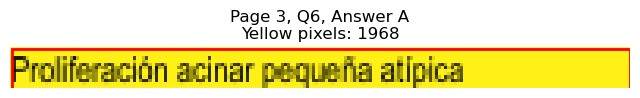

Page 3, Q6 - B: Detected box: x0=68.3, y0=404.9, x1=209.2, y1=417.6
Page 3, Q6, B: Yellow pixels: 187
Page 3, Q6, B: Total non-white pixels: 909
Page 3, Q6, B: Yellow percentage: 20.6%


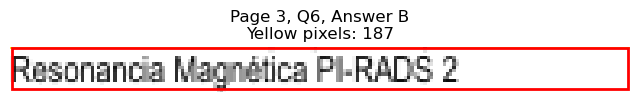

Page 3, Q6 - C: Detected box: x0=327.5, y0=392.3, x1=385.7, y1=405.0
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 299
Page 3, Q6, C: Yellow percentage: 0.0%


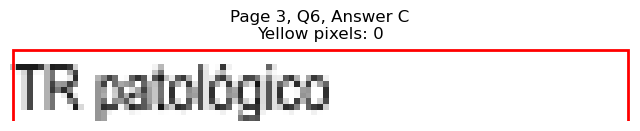

Page 3, Q6 - D: Detected box: x0=327.5, y0=404.9, x1=402.8, y1=417.6
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 388
Page 3, Q6, D: Yellow percentage: 0.0%


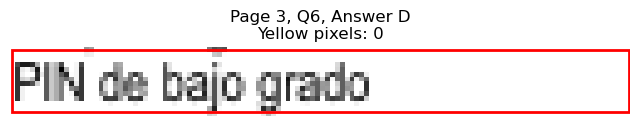


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=442.8, x1=190.1, y1=455.5
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 577
Page 3, Q7, A: Yellow percentage: 0.0%


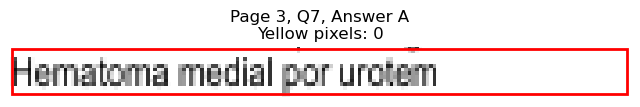

Page 3, Q7 - B: Detected box: x0=68.3, y0=455.5, x1=315.0, y1=468.1
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 1186
Page 3, Q7, B: Yellow percentage: 0.0%


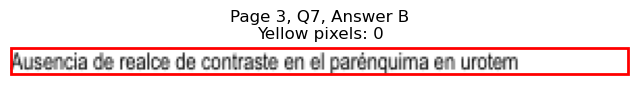

Page 3, Q7 - C: Detected box: x0=68.8, y0=468.1, x1=307.0, y1=480.7
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 1149
Page 3, Q7, C: Yellow percentage: 0.0%


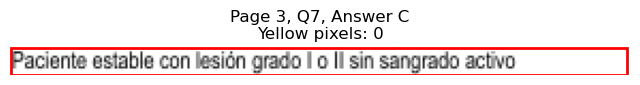

Page 3, Q7 - D: Detected box: x0=68.8, y0=480.8, x1=244.8, y1=493.4
Page 3, Q7, D: Yellow pixels: 2022
Page 3, Q7, D: Total non-white pixels: 3178
Page 3, Q7, D: Yellow percentage: 63.6%


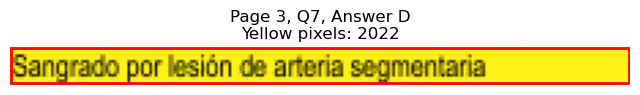


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=518.6, x1=121.5, y1=531.2
Page 3, Q8, A: Yellow pixels: 1133
Page 3, Q8, A: Total non-white pixels: 1456
Page 3, Q8, A: Yellow percentage: 77.8%


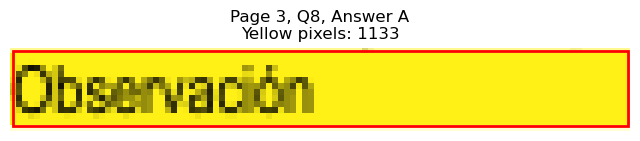

Page 3, Q8 - B: Detected box: x0=68.3, y0=531.2, x1=149.1, y1=543.8
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 523
Page 3, Q8, B: Yellow percentage: 0.0%


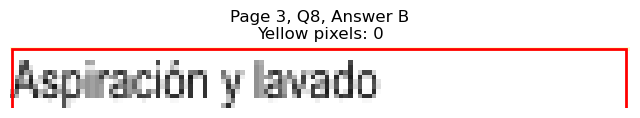

Page 3, Q8 - C: Detected box: x0=327.5, y0=518.6, x1=433.9, y1=531.2
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 545
Page 3, Q8, C: Yellow percentage: 0.0%


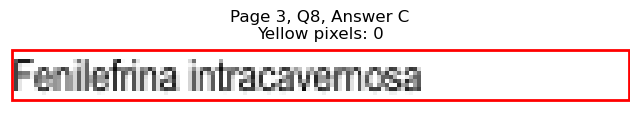

Page 3, Q8 - D: Detected box: x0=327.5, y0=531.2, x1=417.3, y1=543.8
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 458
Page 3, Q8, D: Yellow percentage: 0.0%


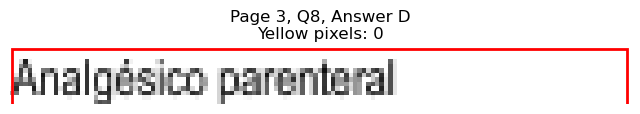


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=56.6, y0=594.3, x1=65.2, y1=607.0
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 67
Page 3, Q9, A: Yellow percentage: 0.0%


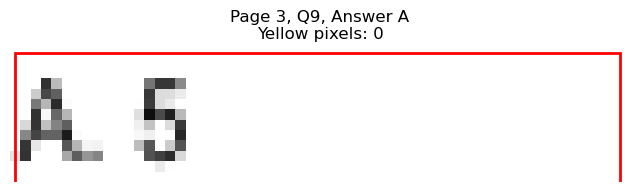

Page 3, Q9 - B: Detected box: x0=56.6, y0=606.9, x1=65.2, y1=619.6
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 73
Page 3, Q9, B: Yellow percentage: 0.0%


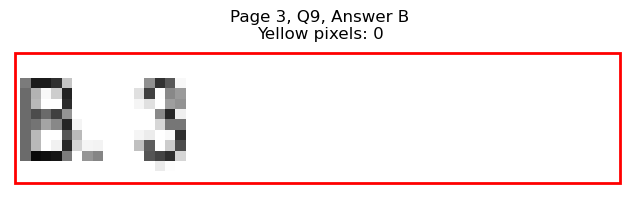

Page 3, Q9 - C: Detected box: x0=315.4, y0=594.3, x1=324.4, y1=607.0
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 122
Page 3, Q9, C: Yellow percentage: 0.0%


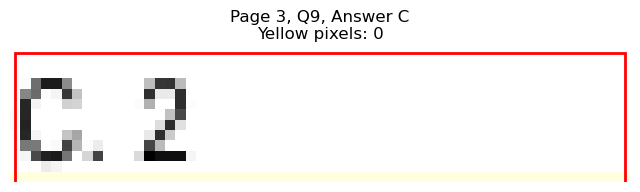

Page 3, Q9 - D: Detected box: x0=315.4, y0=606.9, x1=324.4, y1=619.6
Page 3, Q9, D: Yellow pixels: 726
Page 3, Q9, D: Total non-white pixels: 840
Page 3, Q9, D: Yellow percentage: 86.4%


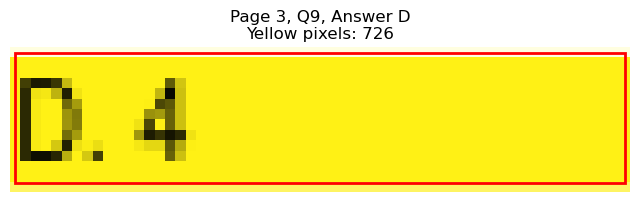


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=644.9, x1=143.1, y1=657.5
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 398
Page 3, Q10, A: Yellow percentage: 0.0%


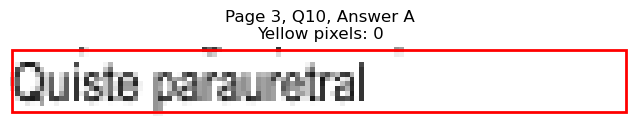

Page 3, Q10 - B: Detected box: x0=68.3, y0=657.5, x1=143.5, y1=670.1
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 390
Page 3, Q10, B: Yellow percentage: 0.0%


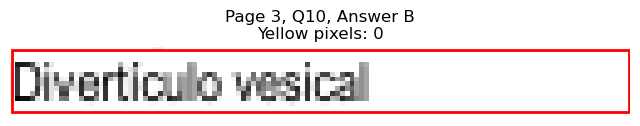

Page 3, Q10 - C: Detected box: x0=327.5, y0=644.9, x1=365.7, y1=657.5
Page 3, Q10, C: Yellow pixels: 987
Page 3, Q10, C: Total non-white pixels: 1246
Page 3, Q10, C: Yellow percentage: 79.2%


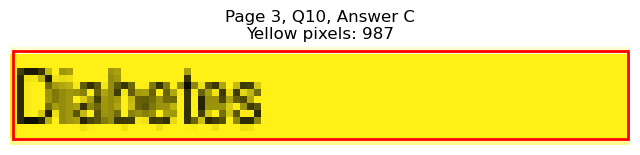

Page 3, Q10 - D: Detected box: x0=327.5, y0=657.5, x1=392.7, y1=670.1
Page 3, Q10, D: Yellow pixels: 116
Page 3, Q10, D: Total non-white pixels: 438
Page 3, Q10, D: Yellow percentage: 26.5%


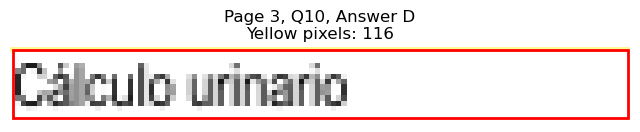


Page 3, Q10 - Selected Answer: C (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=695.4, x1=112.5, y1=708.0
Page 3, Q11, A: Yellow pixels: 95
Page 3, Q11, A: Total non-white pixels: 422
Page 3, Q11, A: Yellow percentage: 22.5%


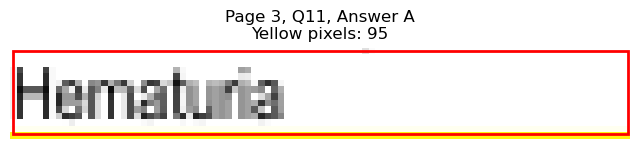

Page 3, Q11 - B: Detected box: x0=68.3, y0=708.0, x1=124.0, y1=720.6
Page 3, Q11, B: Yellow pixels: 1195
Page 3, Q11, B: Total non-white pixels: 1484
Page 3, Q11, B: Yellow percentage: 80.5%


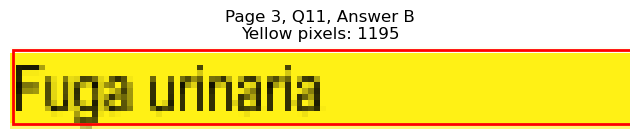

Page 3, Q11 - C: Detected box: x0=327.5, y0=695.4, x1=440.8, y1=708.0
Page 3, Q11, C: Yellow pixels: 0
Page 3, Q11, C: Total non-white pixels: 550
Page 3, Q11, C: Yellow percentage: 0.0%


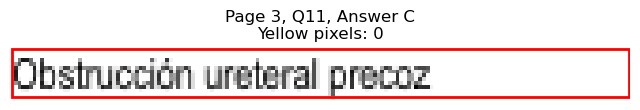

Page 3, Q11 - D: Detected box: x0=327.5, y0=708.0, x1=366.2, y1=720.6
Page 3, Q11, D: Yellow pixels: 0
Page 3, Q11, D: Total non-white pixels: 177
Page 3, Q11, D: Yellow percentage: 0.0%


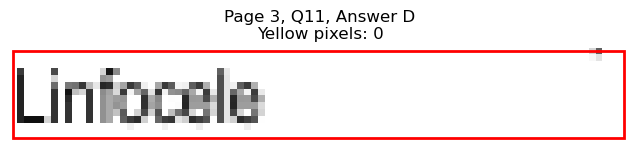


Page 3, Q11 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=244.4, y1=127.3
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 890
Page 4, Q1, A: Yellow percentage: 0.0%


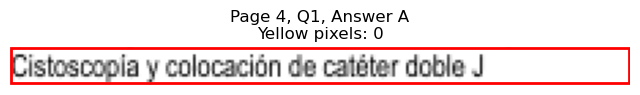

Page 4, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=158.1, y1=139.9
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 464
Page 4, Q1, B: Yellow percentage: 0.0%


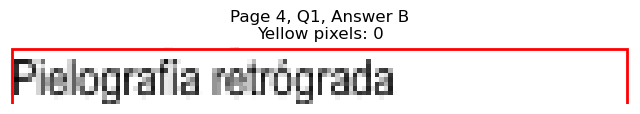

Page 4, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=485.7, y1=127.3
Page 4, Q1, C: Yellow pixels: 1871
Page 4, Q1, C: Total non-white pixels: 2926
Page 4, Q1, C: Yellow percentage: 63.9%


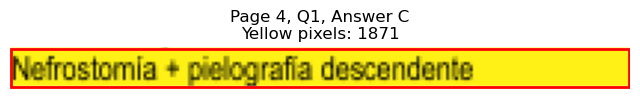

Page 4, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=416.3, y1=139.9
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 557
Page 4, Q1, D: Yellow percentage: 0.0%


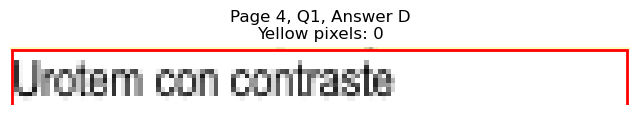


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=85.8, y1=190.4
Page 4, Q2, A: Yellow pixels: 68
Page 4, Q2, A: Total non-white pixels: 151
Page 4, Q2, A: Yellow percentage: 45.0%


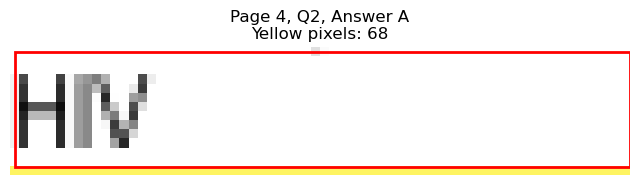

Page 4, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=106.5, y1=203.0
Page 4, Q2, B: Yellow pixels: 1006
Page 4, Q2, B: Total non-white pixels: 1157
Page 4, Q2, B: Yellow percentage: 86.9%


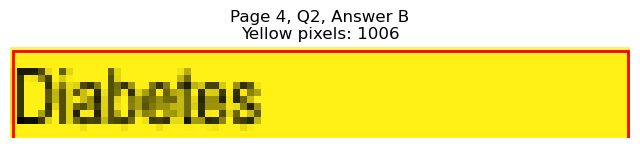

Page 4, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=404.8, y1=190.4
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 386
Page 4, Q2, C: Yellow percentage: 0.0%


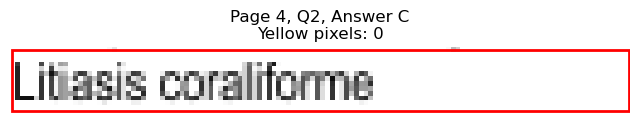

Page 4, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=381.7, y1=203.0
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 267
Page 4, Q2, D: Yellow percentage: 0.0%


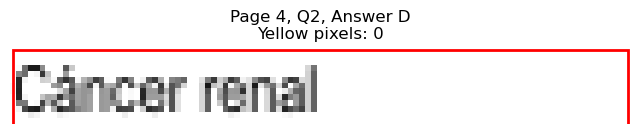


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=143.5, y1=266.1
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 412
Page 4, Q3, A: Yellow percentage: 0.0%


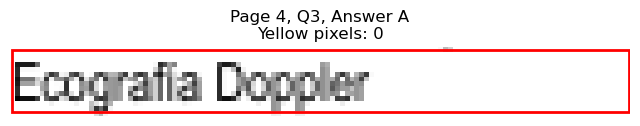

Page 4, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=118.0, y1=278.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 273
Page 4, Q3, B: Yellow percentage: 0.0%


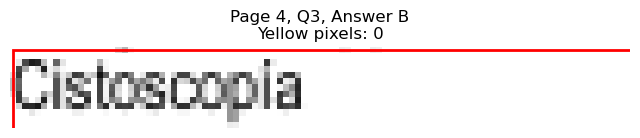

Page 4, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=473.5, y1=266.1
Page 4, Q3, C: Yellow pixels: 1943
Page 4, Q3, C: Total non-white pixels: 2758
Page 4, Q3, C: Yellow percentage: 70.4%


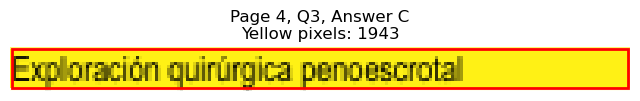

Page 4, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=523.2, y1=278.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 1220
Page 4, Q3, D: Yellow percentage: 0.0%


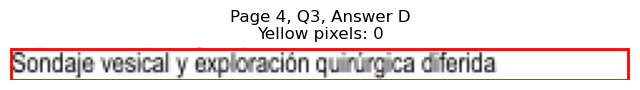


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=109.9, y1=329.3
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 211
Page 4, Q4, A: Yellow percentage: 0.0%


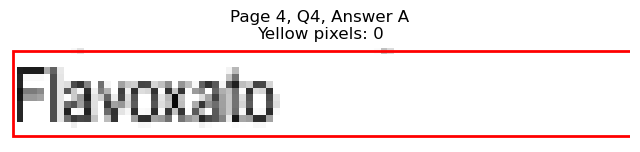

Page 4, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=125.4, y1=341.9
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 282
Page 4, Q4, B: Yellow percentage: 0.0%


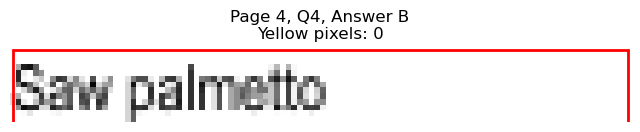

Page 4, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=381.2, y1=329.3
Page 4, Q4, C: Yellow pixels: 1055
Page 4, Q4, C: Total non-white pixels: 1470
Page 4, Q4, C: Yellow percentage: 71.8%


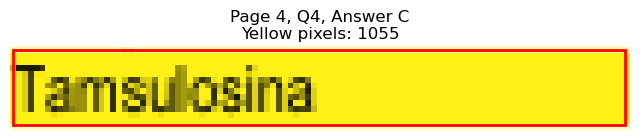

Page 4, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=375.2, y1=341.9
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 350
Page 4, Q4, D: Yellow percentage: 0.0%


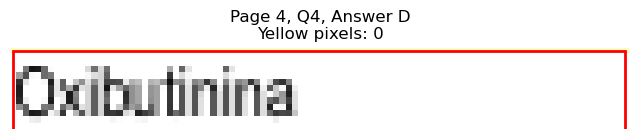


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=166.6, y1=379.8
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 486
Page 4, Q5, A: Yellow percentage: 0.0%


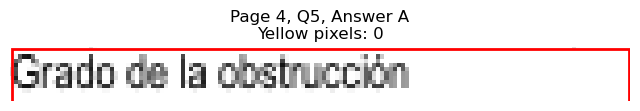

Page 4, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=143.1, y1=392.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 390
Page 4, Q5, B: Yellow percentage: 0.0%


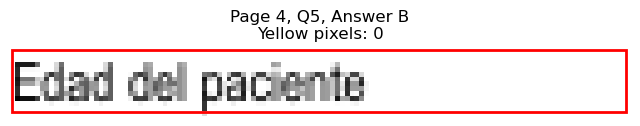

Page 4, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=408.8, y1=379.8
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 545
Page 4, Q5, C: Yellow percentage: 0.0%


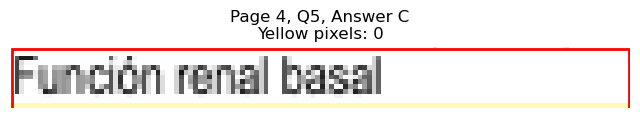

Page 4, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=436.9, y1=392.4
Page 4, Q5, D: Yellow pixels: 1504
Page 4, Q5, D: Total non-white pixels: 2240
Page 4, Q5, D: Yellow percentage: 67.1%


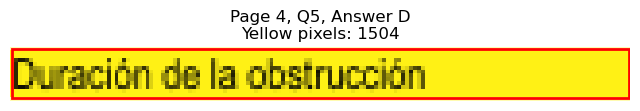


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=112.5, y1=442.9
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 310
Page 4, Q6, A: Yellow percentage: 0.0%


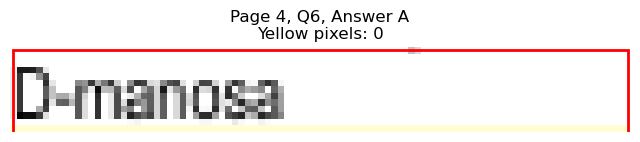

Page 4, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=97.3, y1=455.5
Page 4, Q6, B: Yellow pixels: 928
Page 4, Q6, B: Total non-white pixels: 1120
Page 4, Q6, B: Yellow percentage: 82.9%


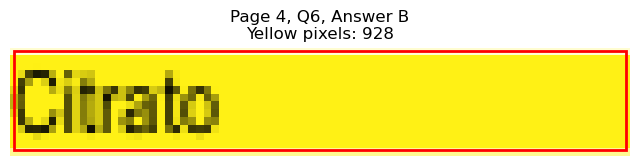

Page 4, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=374.2, y1=442.9
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 219
Page 4, Q6, C: Yellow percentage: 0.0%


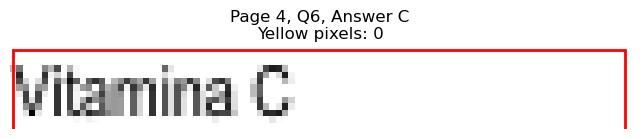

Page 4, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=386.7, y1=455.5
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 275
Page 4, Q6, D: Yellow percentage: 0.0%


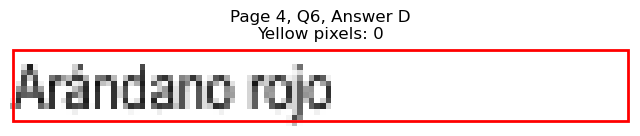


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=211.7, y1=493.4
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 634
Page 4, Q7, A: Yellow percentage: 0.0%


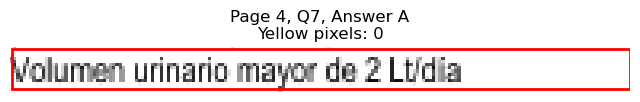

Page 4, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=180.7, y1=506.0
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 541
Page 4, Q7, B: Yellow percentage: 0.0%


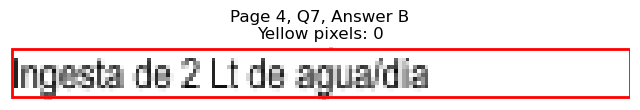

Page 4, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=390.2, y1=493.4
Page 4, Q7, C: Yellow pixels: 114
Page 4, Q7, C: Total non-white pixels: 442
Page 4, Q7, C: Yellow percentage: 25.8%


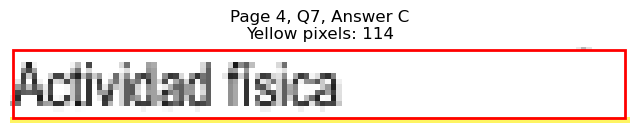

Page 4, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=445.4, y1=506.0
Page 4, Q7, D: Yellow pixels: 1723
Page 4, Q7, D: Total non-white pixels: 2199
Page 4, Q7, D: Yellow percentage: 78.4%


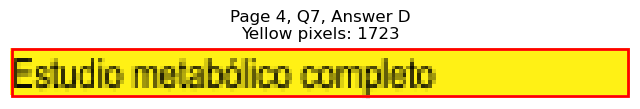


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=179.2, y1=543.8
Page 4, Q8, A: Yellow pixels: 1682
Page 4, Q8, A: Total non-white pixels: 2106
Page 4, Q8, A: Yellow percentage: 79.9%


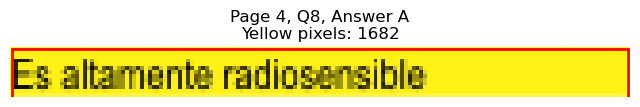

Page 4, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=296.1, y1=556.4
Page 4, Q8, B: Yellow pixels: 279
Page 4, Q8, B: Total non-white pixels: 1383
Page 4, Q8, B: Yellow percentage: 20.2%


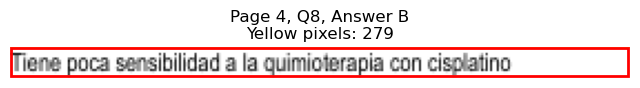

Page 4, Q8 - C: Detected box: x0=68.8, y0=556.5, x1=384.2, y1=569.2
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 1503
Page 4, Q8, C: Yellow percentage: 0.0%


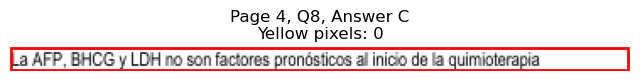

Page 4, Q8 - D: Detected box: x0=68.8, y0=569.1, x1=200.2, y1=581.8
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 653
Page 4, Q8, D: Yellow percentage: 0.0%


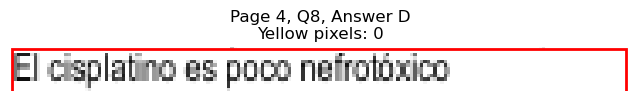


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=80.9, y1=632.3
Page 4, Q9, A: Yellow pixels: 715
Page 4, Q9, A: Total non-white pixels: 882
Page 4, Q9, A: Yellow percentage: 81.1%


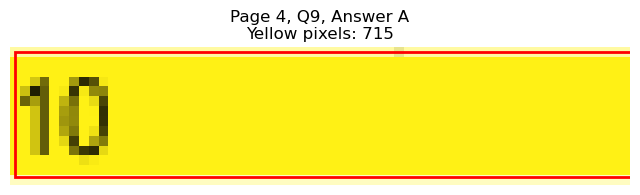

Page 4, Q9 - B: Detected box: x0=56.6, y0=632.2, x1=65.2, y1=644.9
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 133
Page 4, Q9, B: Yellow percentage: 0.0%


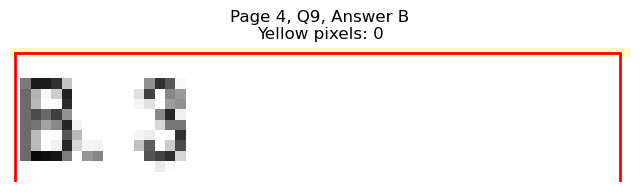

Page 4, Q9 - C: Detected box: x0=315.4, y0=619.6, x1=324.4, y1=632.3
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 69
Page 4, Q9, C: Yellow percentage: 0.0%


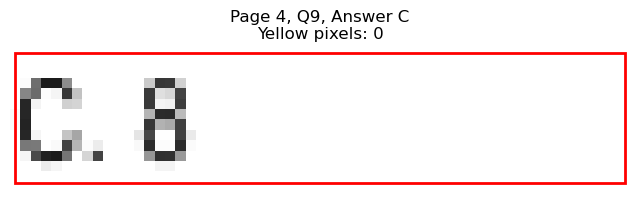

Page 4, Q9 - D: Detected box: x0=315.4, y0=632.2, x1=324.4, y1=644.9
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 71
Page 4, Q9, D: Yellow percentage: 0.0%


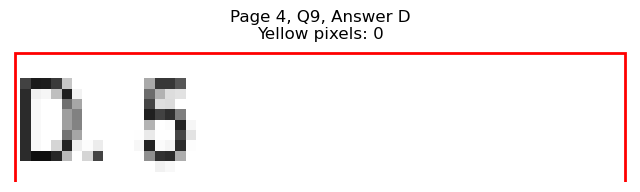


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=171.1, y1=708.0
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 541
Page 4, Q10, A: Yellow percentage: 0.0%


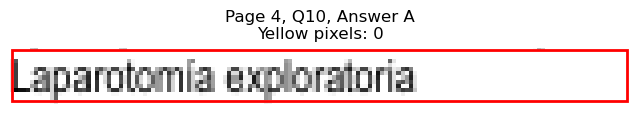

Page 4, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=302.8, y1=720.6
Page 4, Q10, B: Yellow pixels: 285
Page 4, Q10, B: Total non-white pixels: 1441
Page 4, Q10, B: Yellow percentage: 19.8%


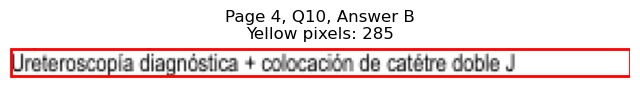

Page 4, Q10 - C: Detected box: x0=68.8, y0=720.6, x1=212.7, y1=733.2
Page 4, Q10, C: Yellow pixels: 1970
Page 4, Q10, C: Total non-white pixels: 2730
Page 4, Q10, C: Yellow percentage: 72.2%


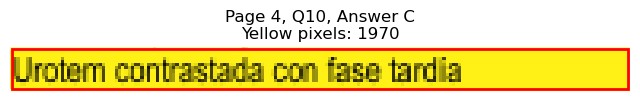

Page 4, Q10 - D: Detected box: x0=68.8, y0=733.2, x1=168.1, y1=745.8
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 652
Page 4, Q10, D: Yellow percentage: 0.0%


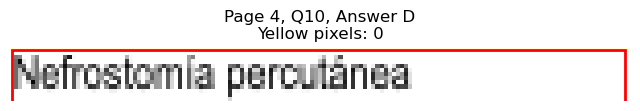


Page 4, Q10 - Selected Answer: C (based on yellow pixel count)





Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=118.9, y1=102.1
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 244
Page 5, Q1, A: Yellow percentage: 0.0%


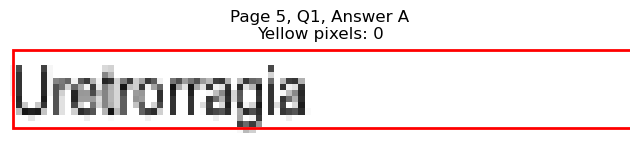

Page 5, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=153.6, y1=114.7
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 448
Page 5, Q1, B: Yellow percentage: 0.0%


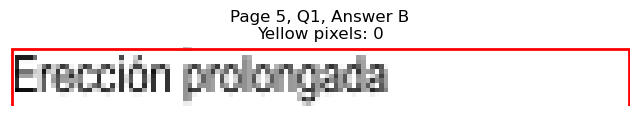

Page 5, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=480.0, y1=102.1
Page 5, Q1, C: Yellow pixels: 203
Page 5, Q1, C: Total non-white pixels: 968
Page 5, Q1, C: Yellow percentage: 21.0%


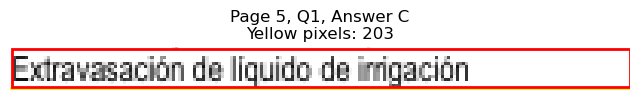

Page 5, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=441.4, y1=114.7
Page 5, Q1, D: Yellow pixels: 1718
Page 5, Q1, D: Total non-white pixels: 2145
Page 5, Q1, D: Yellow percentage: 80.1%


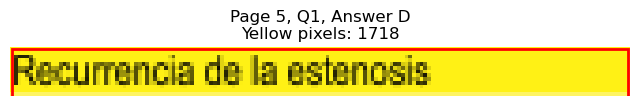


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=190.1, y1=152.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 610
Page 5, Q2, A: Yellow percentage: 0.0%


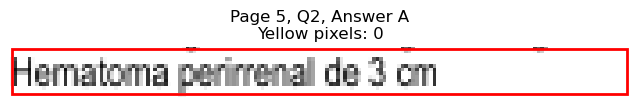

Page 5, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=220.8, y1=165.2
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 753
Page 5, Q2, B: Yellow percentage: 0.0%


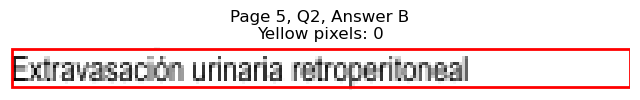

Page 5, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=515.1, y1=152.6
Page 5, Q2, C: Yellow pixels: 213
Page 5, Q2, C: Total non-white pixels: 1177
Page 5, Q2, C: Yellow percentage: 18.1%


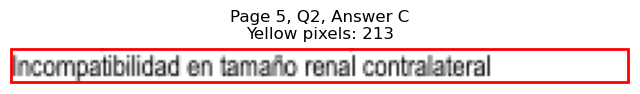

Page 5, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=485.5, y1=165.2
Page 5, Q2, D: Yellow pixels: 2100
Page 5, Q2, D: Total non-white pixels: 2926
Page 5, Q2, D: Yellow percentage: 71.8%


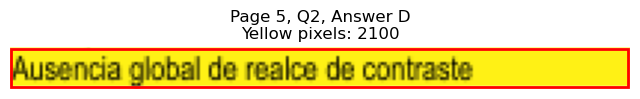


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=190.3, x1=115.5, y1=203.0
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 226
Page 5, Q3, A: Yellow percentage: 0.0%


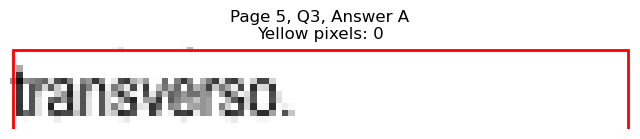

Page 5, Q3 - B: Detected box: x0=68.3, y0=202.9, x1=138.5, y1=215.6
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 360
Page 5, Q3, B: Yellow percentage: 0.0%


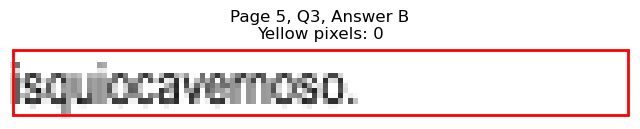

Page 5, Q3 - C: Detected box: x0=327.5, y0=190.3, x1=374.7, y1=203.0
Page 5, Q3, C: Yellow pixels: 1113
Page 5, Q3, C: Total non-white pixels: 1274
Page 5, Q3, C: Yellow percentage: 87.4%


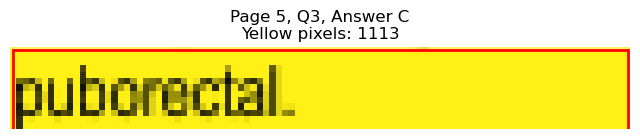

Page 5, Q3 - D: Detected box: x0=327.5, y0=202.9, x1=395.8, y1=215.6
Page 5, Q3, D: Yellow pixels: 118
Page 5, Q3, D: Total non-white pixels: 459
Page 5, Q3, D: Yellow percentage: 25.7%


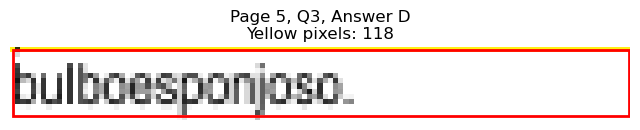


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=253.5, x1=259.8, y1=266.1
Page 5, Q4, A: Yellow pixels: 2055
Page 5, Q4, A: Total non-white pixels: 2996
Page 5, Q4, A: Yellow percentage: 68.6%


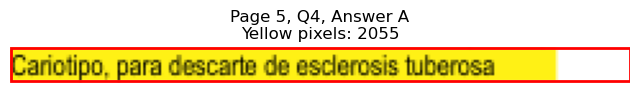

Page 5, Q4 - B: Detected box: x0=68.3, y0=266.1, x1=193.2, y1=278.7
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 815
Page 5, Q4, B: Yellow percentage: 0.0%


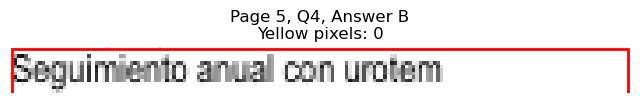

Page 5, Q4 - C: Detected box: x0=327.5, y0=253.5, x1=438.9, y1=266.1
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 593
Page 5, Q4, C: Yellow percentage: 0.0%


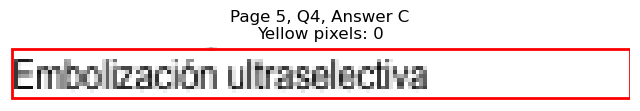

Page 5, Q4 - D: Detected box: x0=327.5, y0=266.1, x1=394.7, y1=278.7
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 330
Page 5, Q4, D: Yellow percentage: 0.0%


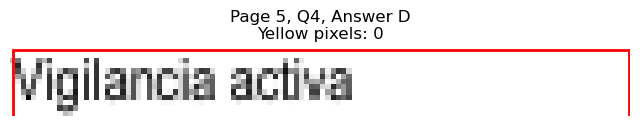


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=171.6, y1=329.3
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 523
Page 5, Q5, A: Yellow percentage: 0.0%


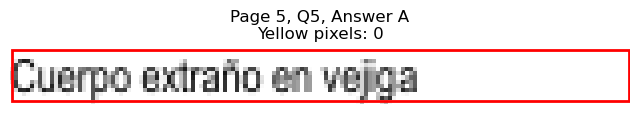

Page 5, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=157.1, y1=341.9
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 417
Page 5, Q5, B: Yellow percentage: 0.0%


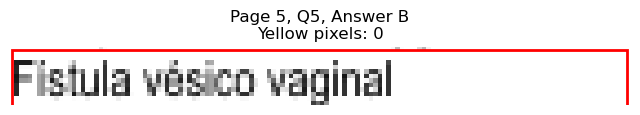

Page 5, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=414.3, y1=329.3
Page 5, Q5, C: Yellow pixels: 138
Page 5, Q5, C: Total non-white pixels: 573
Page 5, Q5, C: Yellow percentage: 24.1%


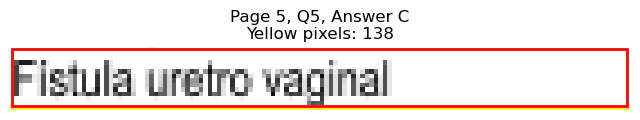

Page 5, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=415.3, y1=341.9
Page 5, Q5, D: Yellow pixels: 1488
Page 5, Q5, D: Total non-white pixels: 1807
Page 5, Q5, D: Yellow percentage: 82.3%


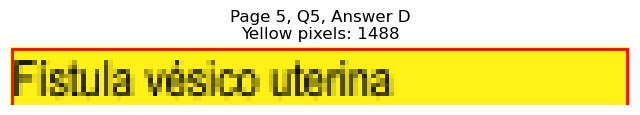


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=392.3, x1=135.5, y1=405.0
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 343
Page 5, Q6, A: Yellow percentage: 0.0%


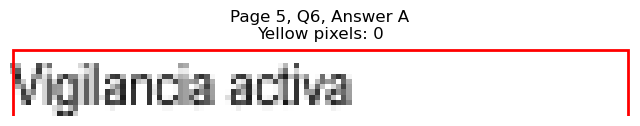

Page 5, Q6 - B: Detected box: x0=68.3, y0=404.9, x1=159.1, y1=417.6
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 449
Page 5, Q6, B: Yellow percentage: 0.0%


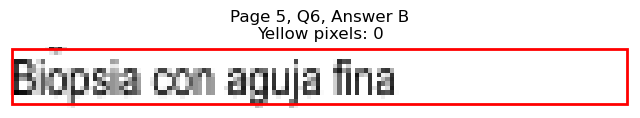

Page 5, Q6 - C: Detected box: x0=327.5, y0=392.3, x1=396.8, y1=405.0
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 472
Page 5, Q6, C: Yellow percentage: 0.0%


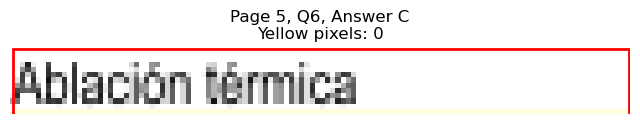

Page 5, Q6 - D: Detected box: x0=327.5, y0=404.9, x1=408.3, y1=417.6
Page 5, Q6, D: Yellow pixels: 1403
Page 5, Q6, D: Total non-white pixels: 1848
Page 5, Q6, D: Yellow percentage: 75.9%


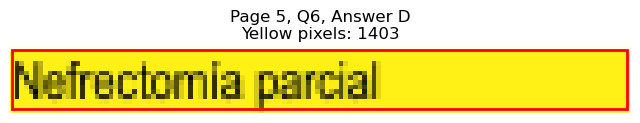


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=176.2, y1=480.7
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 551
Page 5, Q7, A: Yellow percentage: 0.0%


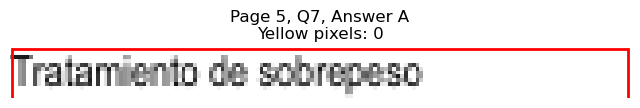

Page 5, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=169.1, y1=493.4
Page 5, Q7, B: Yellow pixels: 1419
Page 5, Q7, B: Total non-white pixels: 2128
Page 5, Q7, B: Yellow percentage: 66.7%


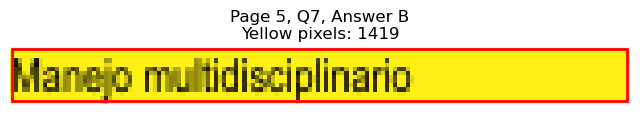

Page 5, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=439.4, y1=480.7
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 569
Page 5, Q7, C: Yellow percentage: 0.0%


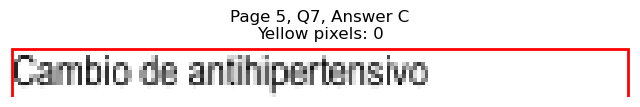

Page 5, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=379.7, y1=493.4
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 289
Page 5, Q7, D: Yellow percentage: 0.0%


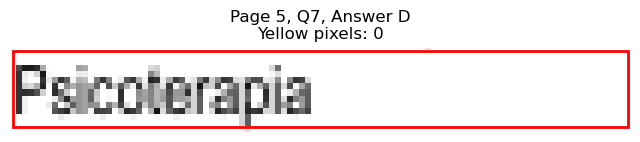


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=310.5, y1=543.8
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 1148
Page 5, Q8, A: Yellow percentage: 0.0%


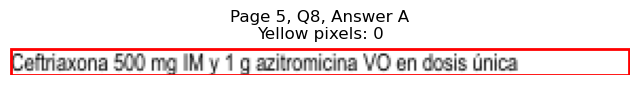

Page 5, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=186.1, y1=556.4
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 576
Page 5, Q8, B: Yellow percentage: 0.0%


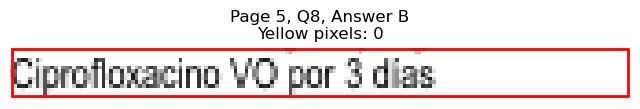

Page 5, Q8 - C: Detected box: x0=68.8, y0=556.5, x1=311.0, y1=569.2
Page 5, Q8, C: Yellow pixels: 2912
Page 5, Q8, C: Total non-white pixels: 4102
Page 5, Q8, C: Yellow percentage: 71.0%


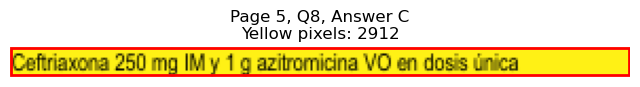

Page 5, Q8 - D: Detected box: x0=68.8, y0=569.1, x1=293.4, y1=581.8
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 1366
Page 5, Q8, D: Yellow percentage: 0.0%


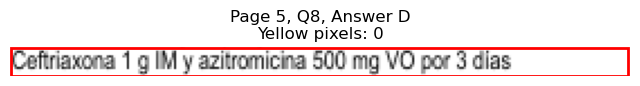


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=606.9, x1=112.5, y1=619.6
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 234
Page 5, Q9, A: Yellow percentage: 0.0%


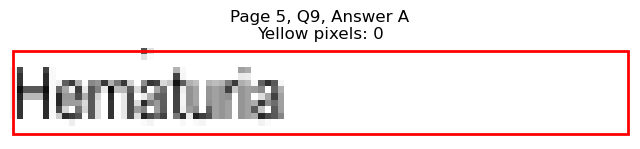

Page 5, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=106.9, y1=632.3
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 183
Page 5, Q9, B: Yellow percentage: 0.0%


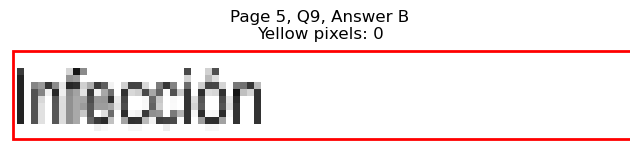

Page 5, Q9 - C: Detected box: x0=327.5, y0=606.9, x1=364.1, y1=619.6
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 180
Page 5, Q9, C: Yellow percentage: 0.0%


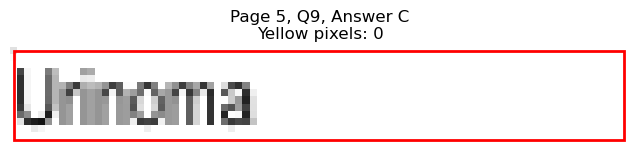

Page 5, Q9 - D: Detected box: x0=327.5, y0=102.0, x1=378.7, y1=114.7
Page 5, Q9, D: Yellow pixels: 943
Page 5, Q9, D: Total non-white pixels: 1326
Page 5, Q9, D: Yellow percentage: 71.1%


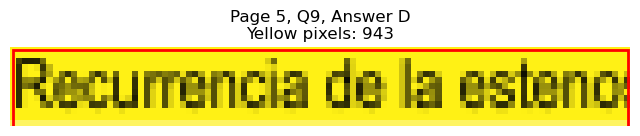


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=682.7, x1=121.9, y1=695.3
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 255
Page 5, Q10, A: Yellow percentage: 0.0%


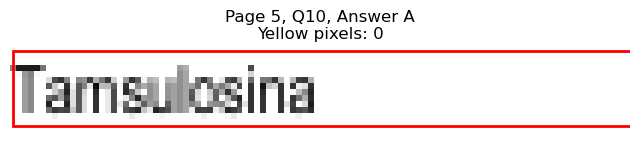

Page 5, Q10 - B: Detected box: x0=68.3, y0=695.4, x1=115.5, y1=708.0
Page 5, Q10, B: Yellow pixels: 1077
Page 5, Q10, B: Total non-white pixels: 1274
Page 5, Q10, B: Yellow percentage: 84.5%


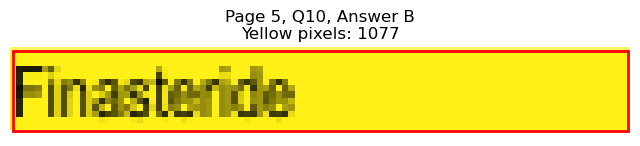

Page 5, Q10 - C: Detected box: x0=327.5, y0=682.7, x1=377.2, y1=695.3
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 250
Page 5, Q10, C: Yellow percentage: 0.0%


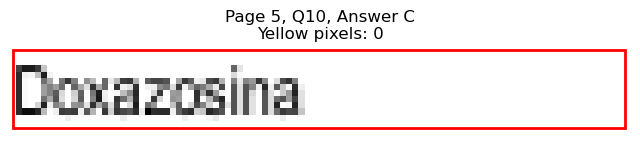

Page 5, Q10 - D: Detected box: x0=327.5, y0=695.4, x1=375.2, y1=708.0
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 251
Page 5, Q10, D: Yellow percentage: 0.0%


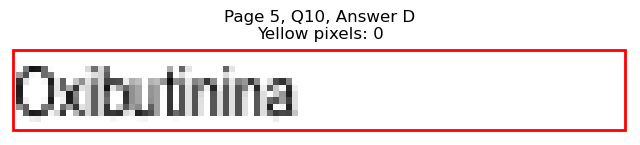


Page 5, Q10 - Selected Answer: B (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=733.2, x1=101.9, y1=745.8
Page 5, Q11, A: Yellow pixels: 967
Page 5, Q11, A: Total non-white pixels: 1092
Page 5, Q11, A: Yellow percentage: 88.6%


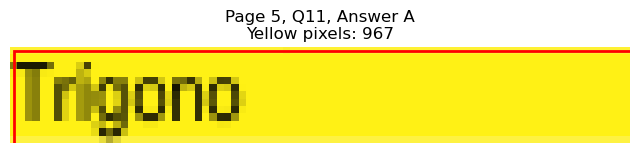

Page 5, Q11 - B: Detected box: x0=68.3, y0=745.8, x1=126.5, y1=758.4
Page 5, Q11, B: Yellow pixels: 108
Page 5, Q11, B: Total non-white pixels: 403
Page 5, Q11, B: Yellow percentage: 26.8%


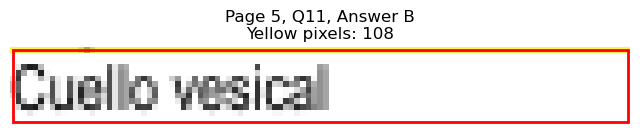

Page 5, Q11 - C: Detected box: x0=327.5, y0=733.2, x1=387.2, y1=745.8
Page 5, Q11, C: Yellow pixels: 0
Page 5, Q11, C: Total non-white pixels: 282
Page 5, Q11, C: Yellow percentage: 0.0%


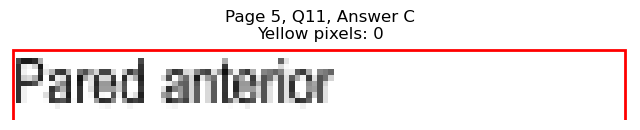

Page 5, Q11 - D: Detected box: x0=327.5, y0=745.8, x1=394.3, y1=758.4
Page 5, Q11, D: Yellow pixels: 0
Page 5, Q11, D: Total non-white pixels: 339
Page 5, Q11, D: Yellow percentage: 0.0%


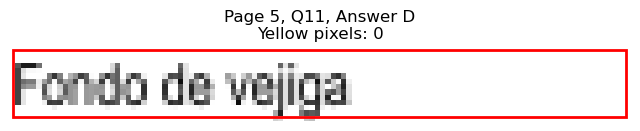


Page 5, Q11 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 12 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=143.5, y1=114.7
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 373
Page 6, Q1, A: Yellow percentage: 0.0%


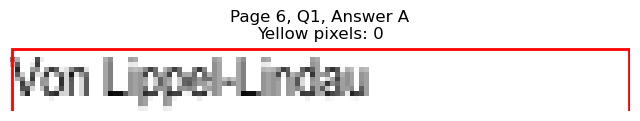

Page 6, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=121.0, y1=127.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 240
Page 6, Q1, B: Yellow percentage: 0.0%


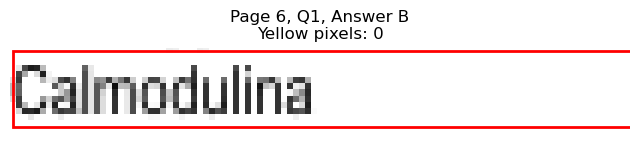

Page 6, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=370.6, y1=114.7
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 321
Page 6, Q1, C: Yellow percentage: 0.0%


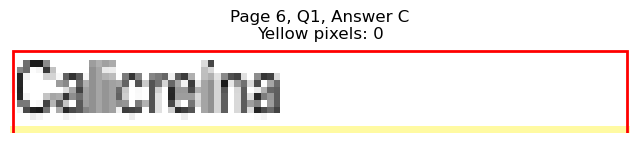

Page 6, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=389.2, y1=127.3
Page 6, Q1, D: Yellow pixels: 1139
Page 6, Q1, D: Total non-white pixels: 1582
Page 6, Q1, D: Yellow percentage: 72.0%


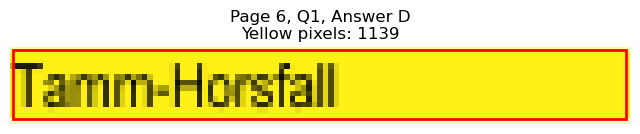


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=136.0, y1=165.2
Page 6, Q2, A: Yellow pixels: 1287
Page 6, Q2, A: Total non-white pixels: 1652
Page 6, Q2, A: Yellow percentage: 77.9%


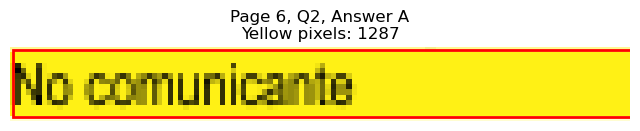

Page 6, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=124.0, y1=177.8
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 371
Page 6, Q2, B: Yellow percentage: 0.0%


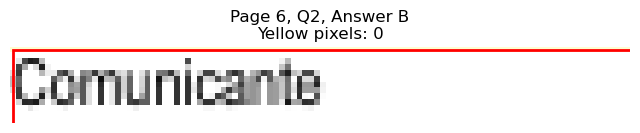

Page 6, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=425.3, y1=165.2
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 509
Page 6, Q2, C: Yellow percentage: 0.0%


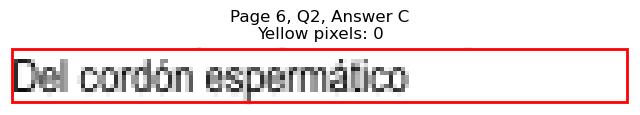

Page 6, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=404.8, y1=177.8
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 388
Page 6, Q2, D: Yellow percentage: 0.0%


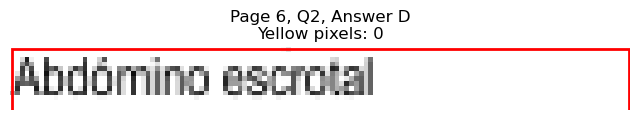


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=255.6, y1=240.9
Page 6, Q3, A: Yellow pixels: 2030
Page 6, Q3, A: Total non-white pixels: 2784
Page 6, Q3, A: Yellow percentage: 72.9%


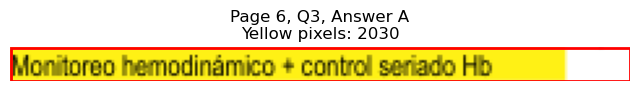

Page 6, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=150.5, y1=253.5
Page 6, Q3, B: Yellow pixels: 133
Page 6, Q3, B: Total non-white pixels: 558
Page 6, Q3, B: Yellow percentage: 23.8%


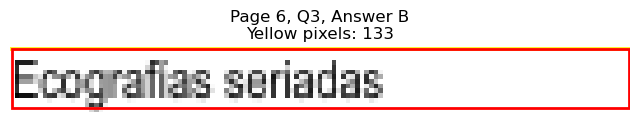

Page 6, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=419.3, y1=240.9
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 488
Page 6, Q3, C: Yellow percentage: 0.0%


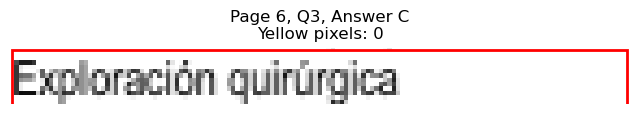

Page 6, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=396.2, y1=253.5
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 348
Page 6, Q3, D: Yellow percentage: 0.0%


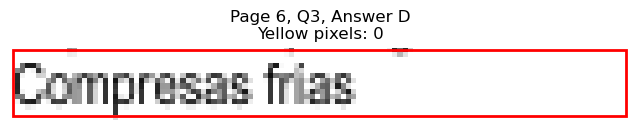


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=172.1, y1=304.1
Page 6, Q4, A: Yellow pixels: 1589
Page 6, Q4, A: Total non-white pixels: 2170
Page 6, Q4, A: Yellow percentage: 73.2%


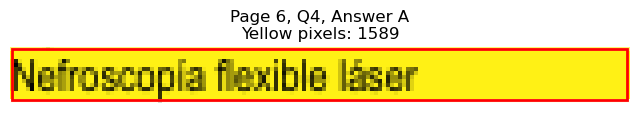

Page 6, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=101.9, y1=316.7
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 245
Page 6, Q4, B: Yellow percentage: 0.0%


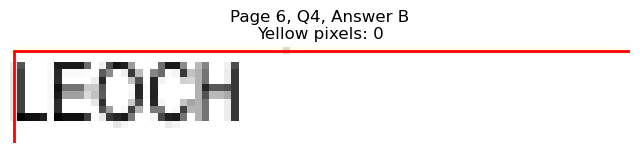

Page 6, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=433.9, y1=304.1
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 539
Page 6, Q4, C: Yellow percentage: 0.0%


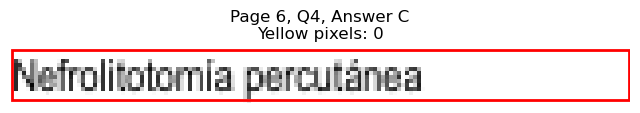

Page 6, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=459.4, y1=316.7
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 692
Page 6, Q4, D: Yellow percentage: 0.0%


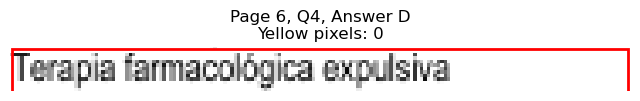


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=132.5, y1=354.6
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 348
Page 6, Q5, A: Yellow percentage: 0.0%


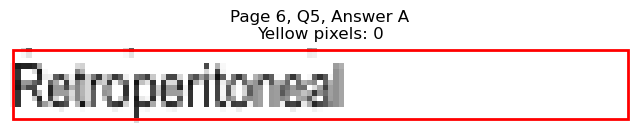

Page 6, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=164.5, y1=367.2
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 485
Page 6, Q5, B: Yellow percentage: 0.0%


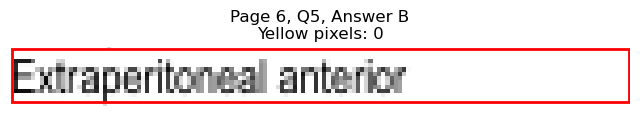

Page 6, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=387.8, y1=354.6
Page 6, Q5, C: Yellow pixels: 1196
Page 6, Q5, C: Total non-white pixels: 1554
Page 6, Q5, C: Yellow percentage: 77.0%


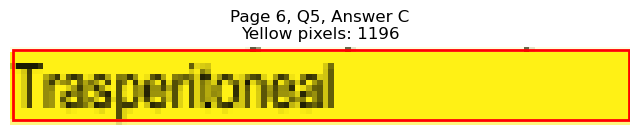

Page 6, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=428.3, y1=367.2
Page 6, Q5, D: Yellow pixels: 152
Page 6, Q5, D: Total non-white pixels: 677
Page 6, Q5, D: Yellow percentage: 22.5%


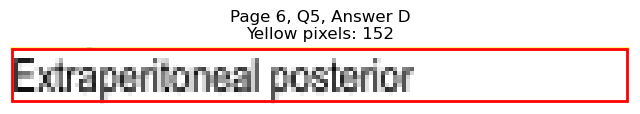


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=404.9, x1=146.5, y1=417.6
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 358
Page 6, Q6, A: Yellow percentage: 0.0%


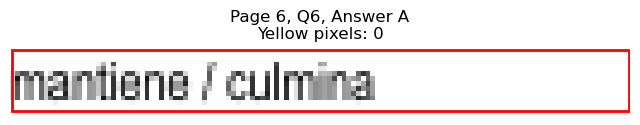

Page 6, Q6 - B: Detected box: x0=68.3, y0=417.6, x1=130.0, y1=430.3
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 290
Page 6, Q6, B: Yellow percentage: 0.0%


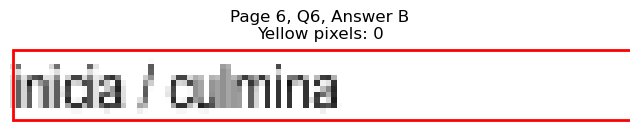

Page 6, Q6 - C: Detected box: x0=327.5, y0=404.9, x1=395.2, y1=417.6
Page 6, Q6, C: Yellow pixels: 1308
Page 6, Q6, C: Total non-white pixels: 1666
Page 6, Q6, C: Yellow percentage: 78.5%


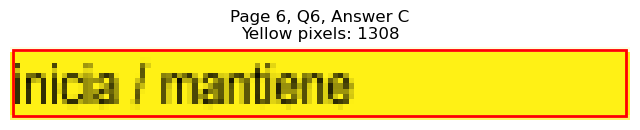

Page 6, Q6 - D: Detected box: x0=327.5, y0=417.6, x1=480.6, y1=430.3
Page 6, Q6, D: Yellow pixels: 204
Page 6, Q6, D: Total non-white pixels: 972
Page 6, Q6, D: Yellow percentage: 21.0%


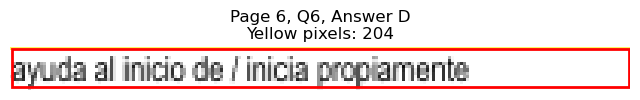


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=143.1, y1=480.7
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 332
Page 6, Q7, A: Yellow percentage: 0.0%


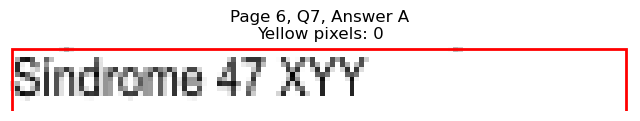

Page 6, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=144.0, y1=493.4
Page 6, Q7, B: Yellow pixels: 1224
Page 6, Q7, B: Total non-white pixels: 1778
Page 6, Q7, B: Yellow percentage: 68.8%


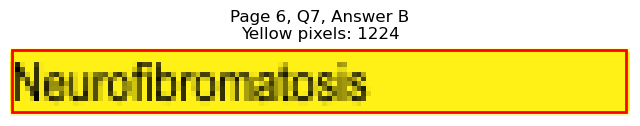

Page 6, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=439.4, y1=480.7
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 566
Page 6, Q7, C: Yellow percentage: 0.0%


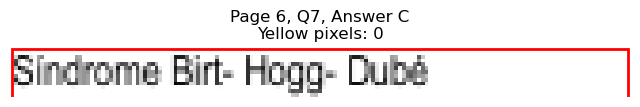

Page 6, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=398.2, y1=493.4
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 349
Page 6, Q7, D: Yellow percentage: 0.0%


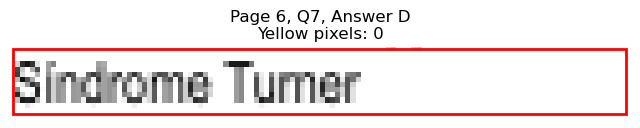


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=518.6, x1=114.5, y1=531.2
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 202
Page 6, Q8, A: Yellow percentage: 0.0%


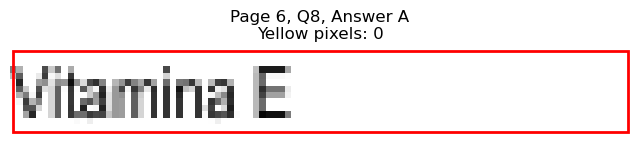

Page 6, Q8 - B: Detected box: x0=68.3, y0=531.2, x1=113.9, y1=543.8
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 217
Page 6, Q8, B: Yellow percentage: 0.0%


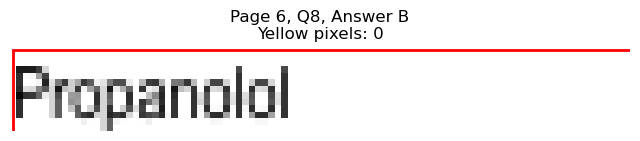

Page 6, Q8 - C: Detected box: x0=327.5, y0=518.6, x1=364.1, y1=531.2
Page 6, Q8, C: Yellow pixels: 989
Page 6, Q8, C: Total non-white pixels: 1232
Page 6, Q8, C: Yellow percentage: 80.3%


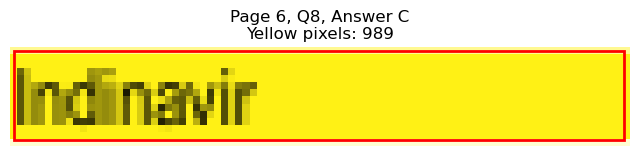

Page 6, Q8 - D: Detected box: x0=327.5, y0=531.2, x1=381.2, y1=543.8
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 374
Page 6, Q8, D: Yellow percentage: 0.0%


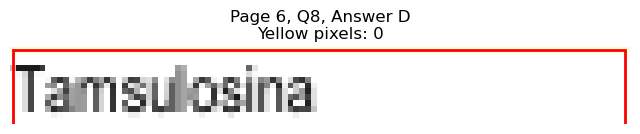


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=88.8, y1=594.4
Page 6, Q9, A: Yellow pixels: 768
Page 6, Q9, A: Total non-white pixels: 994
Page 6, Q9, A: Yellow percentage: 77.3%


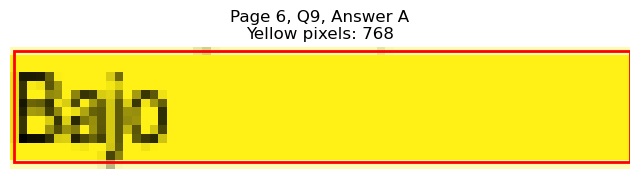

Page 6, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=155.5, y1=607.0
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 568
Page 6, Q9, B: Yellow percentage: 0.0%


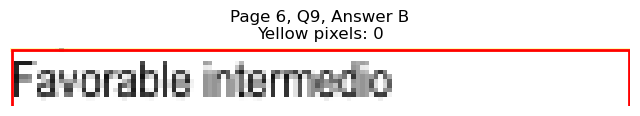

Page 6, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=426.9, y1=594.4
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 522
Page 6, Q9, C: Yellow percentage: 0.0%


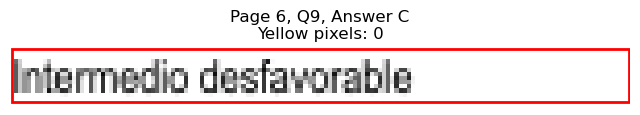

Page 6, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=366.7, y1=607.0
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 200
Page 6, Q9, D: Yellow percentage: 0.0%


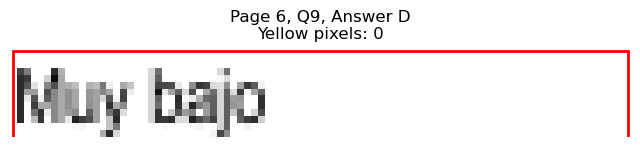


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=127.9, y1=644.9
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 321
Page 6, Q10, A: Yellow percentage: 0.0%


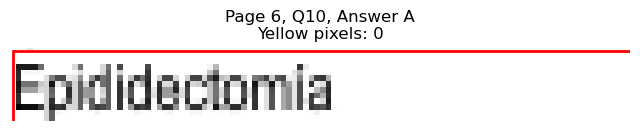

Page 6, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=207.8, y1=657.5
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 715
Page 6, Q10, B: Yellow percentage: 0.0%


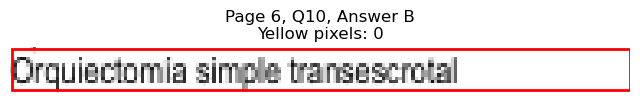

Page 6, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=396.8, y1=644.9
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 477
Page 6, Q10, C: Yellow percentage: 0.0%


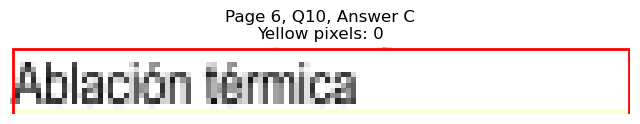

Page 6, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=499.5, y1=657.5
Page 6, Q10, D: Yellow pixels: 2093
Page 6, Q10, D: Total non-white pixels: 2996
Page 6, Q10, D: Yellow percentage: 69.9%


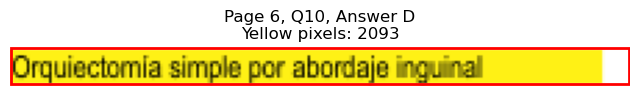


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=68.3, y0=682.7, x1=130.9, y1=695.3
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 275
Page 6, Q11, A: Yellow percentage: 0.0%


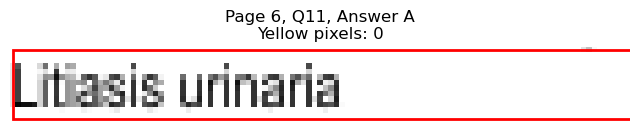

Page 6, Q11 - B: Detected box: x0=68.3, y0=695.4, x1=154.1, y1=708.0
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 463
Page 6, Q11, B: Yellow percentage: 0.0%


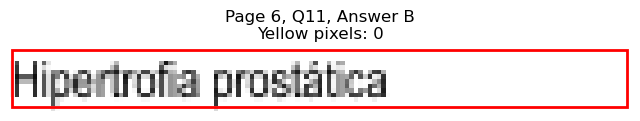

Page 6, Q11 - C: Detected box: x0=327.5, y0=682.7, x1=371.2, y1=695.3
Page 6, Q11, C: Yellow pixels: 965
Page 6, Q11, C: Total non-white pixels: 1330
Page 6, Q11, C: Yellow percentage: 72.6%


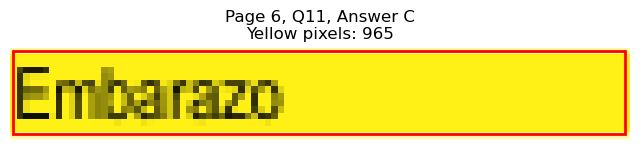

Page 6, Q11 - D: Detected box: x0=327.5, y0=695.4, x1=421.4, y1=708.0
Page 6, Q11, D: Yellow pixels: 0
Page 6, Q11, D: Total non-white pixels: 641
Page 6, Q11, D: Yellow percentage: 0.0%


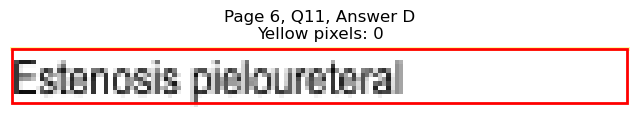


Page 6, Q11 - Selected Answer: C (based on yellow pixel count)




Page 6, Q12 - A: Detected box: x0=68.3, y0=745.8, x1=97.3, y1=758.4
Page 6, Q12, A: Yellow pixels: 0
Page 6, Q12, A: Total non-white pixels: 159
Page 6, Q12, A: Yellow percentage: 0.0%


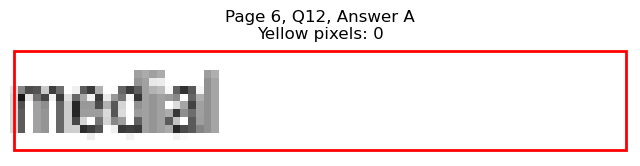

Page 6, Q12 - B: Detected box: x0=68.3, y0=758.5, x1=101.4, y1=771.2
Page 6, Q12, B: Yellow pixels: 0
Page 6, Q12, B: Total non-white pixels: 164
Page 6, Q12, B: Yellow percentage: 0.0%


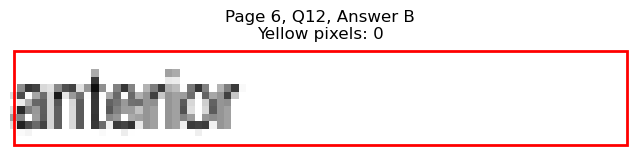

Page 6, Q12 - C: Detected box: x0=327.5, y0=745.8, x1=365.1, y1=758.4
Page 6, Q12, C: Yellow pixels: 0
Page 6, Q12, C: Total non-white pixels: 185
Page 6, Q12, C: Yellow percentage: 0.0%


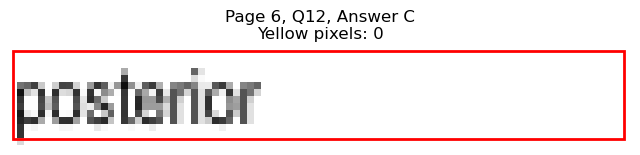

Page 6, Q12 - D: Detected box: x0=327.5, y0=758.5, x1=352.2, y1=771.2
Page 6, Q12, D: Yellow pixels: 875
Page 6, Q12, D: Total non-white pixels: 1064
Page 6, Q12, D: Yellow percentage: 82.2%


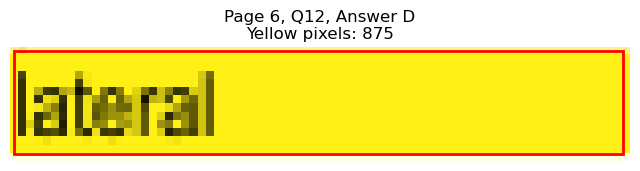


Page 6, Q12 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 12 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=112.5, y1=114.7
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 242
Page 7, Q1, A: Yellow percentage: 0.0%


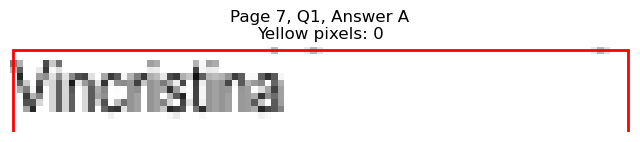

Page 7, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=126.5, y1=127.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 275
Page 7, Q1, B: Yellow percentage: 0.0%


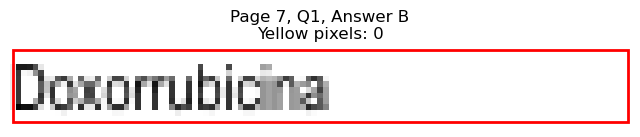

Page 7, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=389.2, y1=114.7
Page 7, Q1, C: Yellow pixels: 1217
Page 7, Q1, C: Total non-white pixels: 1469
Page 7, Q1, C: Yellow percentage: 82.8%


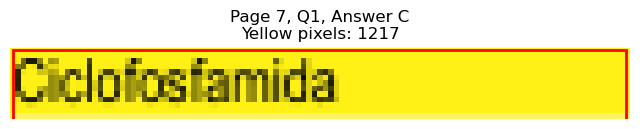

Page 7, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=377.7, y1=127.3
Page 7, Q1, D: Yellow pixels: 101
Page 7, Q1, D: Total non-white pixels: 380
Page 7, Q1, D: Yellow percentage: 26.6%


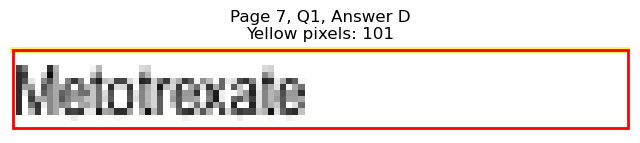


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=113.9, y1=177.8
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 328
Page 7, Q2, A: Yellow percentage: 0.0%


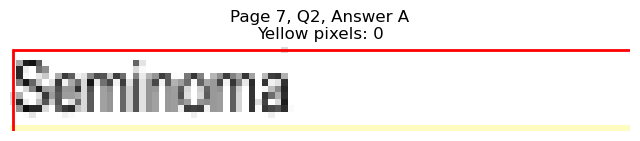

Page 7, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=144.0, y1=190.4
Page 7, Q2, B: Yellow pixels: 1240
Page 7, Q2, B: Total non-white pixels: 1778
Page 7, Q2, B: Yellow percentage: 69.7%


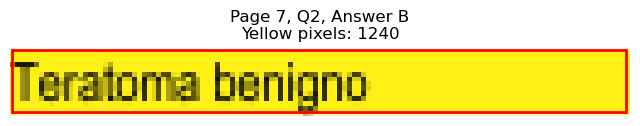

Page 7, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=420.8, y1=177.8
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 450
Page 7, Q2, C: Yellow percentage: 0.0%


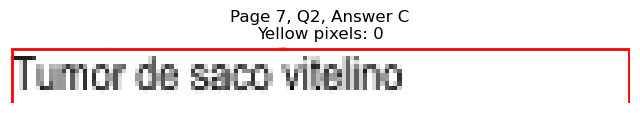

Page 7, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=440.9, y1=190.4
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 554
Page 7, Q2, D: Yellow percentage: 0.0%


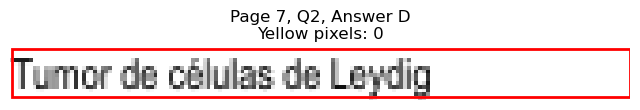


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=132.0, y1=228.3
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 288
Page 7, Q3, A: Yellow percentage: 0.0%


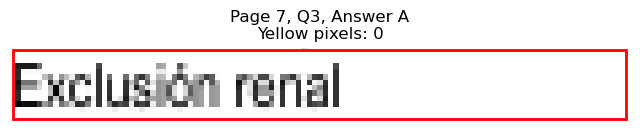

Page 7, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=97.9, y1=240.9
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 163
Page 7, Q3, B: Yellow percentage: 0.0%


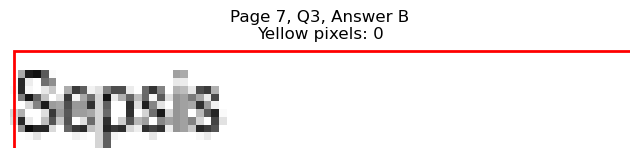

Page 7, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=364.1, y1=228.3
Page 7, Q3, C: Yellow pixels: 88
Page 7, Q3, C: Total non-white pixels: 267
Page 7, Q3, C: Yellow percentage: 33.0%


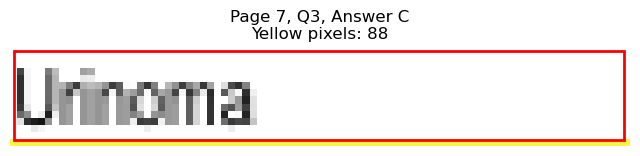

Page 7, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=377.2, y1=240.9
Page 7, Q3, D: Yellow pixels: 1121
Page 7, Q3, D: Total non-white pixels: 1313
Page 7, Q3, D: Yellow percentage: 85.4%


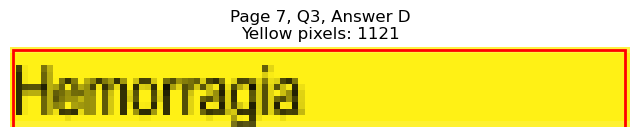


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=210.3, y1=278.7
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 674
Page 7, Q4, A: Yellow percentage: 0.0%


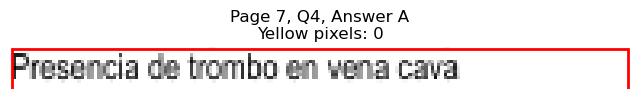

Page 7, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=130.9, y1=291.5
Page 7, Q4, B: Yellow pixels: 1238
Page 7, Q4, B: Total non-white pixels: 1582
Page 7, Q4, B: Yellow percentage: 78.3%


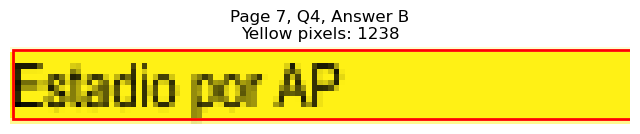

Page 7, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=403.3, y1=278.7
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 365
Page 7, Q4, C: Yellow percentage: 0.0%


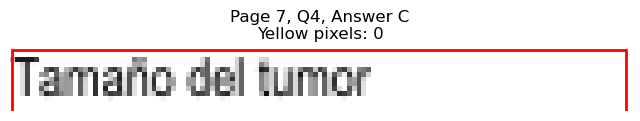

Page 7, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=399.3, y1=291.5
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 355
Page 7, Q4, D: Yellow percentage: 0.0%


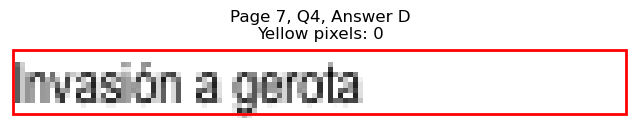


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=167.1, y1=354.6
Page 7, Q5, A: Yellow pixels: 150
Page 7, Q5, A: Total non-white pixels: 640
Page 7, Q5, A: Yellow percentage: 23.4%


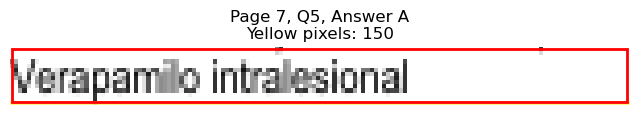

Page 7, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=97.9, y1=367.2
Page 7, Q5, B: Yellow pixels: 920
Page 7, Q5, B: Total non-white pixels: 1120
Page 7, Q5, B: Yellow percentage: 82.1%


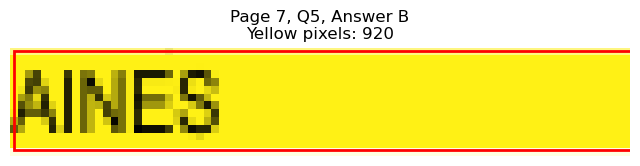

Page 7, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=401.3, y1=354.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 350
Page 7, Q5, C: Yellow percentage: 0.0%


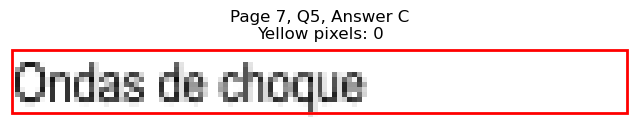

Page 7, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=510.1, y1=367.2
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 929
Page 7, Q5, D: Yellow percentage: 0.0%


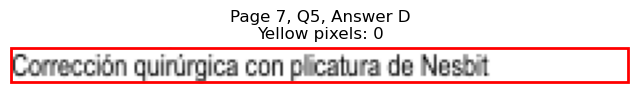


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=404.9, x1=127.9, y1=417.6
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 315
Page 7, Q6, A: Yellow percentage: 0.0%


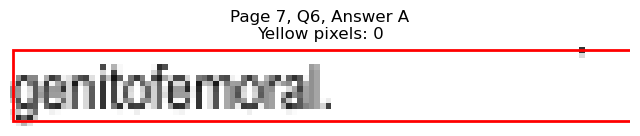

Page 7, Q6 - B: Detected box: x0=68.3, y0=417.6, x1=115.5, y1=430.3
Page 7, Q6, B: Yellow pixels: 1008
Page 7, Q6, B: Total non-white pixels: 1372
Page 7, Q6, B: Yellow percentage: 73.5%


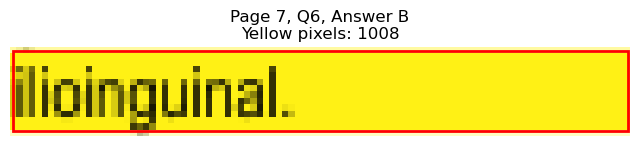

Page 7, Q6 - C: Detected box: x0=327.5, y0=404.9, x1=367.7, y1=417.6
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 179
Page 7, Q6, C: Yellow percentage: 0.0%


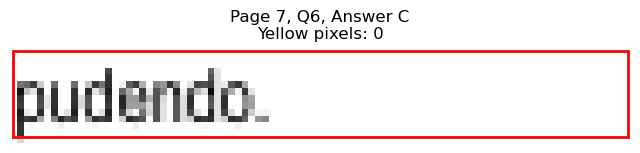

Page 7, Q6 - D: Detected box: x0=327.5, y0=417.6, x1=371.2, y1=430.3
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 214
Page 7, Q6, D: Yellow percentage: 0.0%


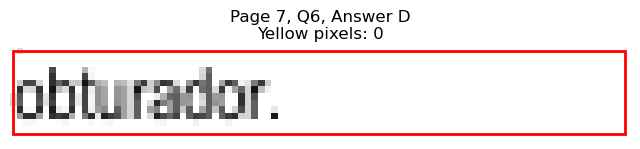


Page 7, Q6 - Selected Answer: B (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=455.5, x1=123.5, y1=468.1
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 283
Page 7, Q7, A: Yellow percentage: 0.0%


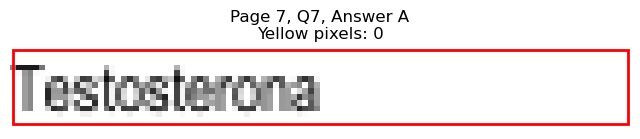

Page 7, Q7 - B: Detected box: x0=68.3, y0=468.1, x1=110.9, y1=480.7
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 209
Page 7, Q7, B: Yellow percentage: 0.0%


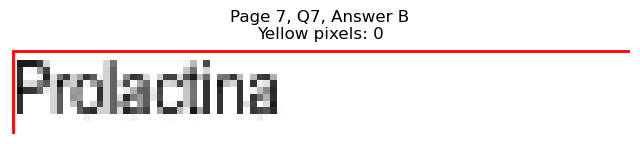

Page 7, Q7 - C: Detected box: x0=327.5, y0=455.5, x1=348.1, y1=468.1
Page 7, Q7, C: Yellow pixels: 72
Page 7, Q7, C: Total non-white pixels: 171
Page 7, Q7, C: Yellow percentage: 42.1%


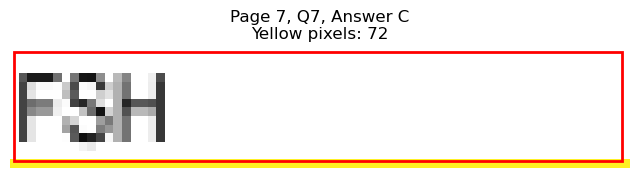

Page 7, Q7 - D: Detected box: x0=327.5, y0=468.1, x1=408.3, y1=480.7
Page 7, Q7, D: Yellow pixels: 1370
Page 7, Q7, D: Total non-white pixels: 1716
Page 7, Q7, D: Yellow percentage: 79.8%


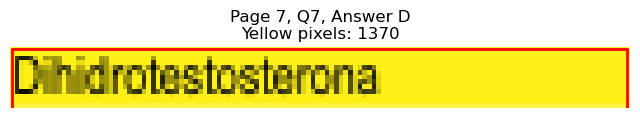


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=506.0, x1=143.5, y1=518.6
Page 7, Q8, A: Yellow pixels: 1323
Page 7, Q8, A: Total non-white pixels: 1764
Page 7, Q8, A: Yellow percentage: 75.0%


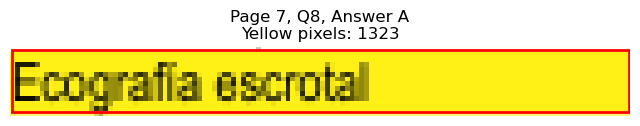

Page 7, Q8 - B: Detected box: x0=68.3, y0=518.6, x1=116.9, y1=531.2
Page 7, Q8, B: Yellow pixels: 98
Page 7, Q8, B: Total non-white pixels: 336
Page 7, Q8, B: Yellow percentage: 29.2%


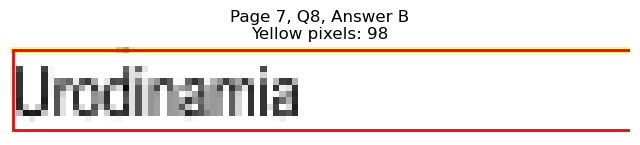

Page 7, Q8 - C: Detected box: x0=327.5, y0=506.0, x1=417.3, y1=518.6
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 463
Page 7, Q8, C: Yellow percentage: 0.0%


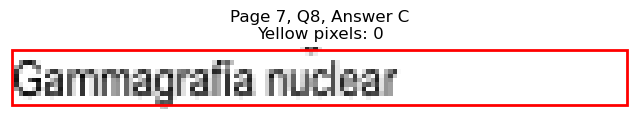

Page 7, Q8 - D: Detected box: x0=327.5, y0=518.6, x1=376.1, y1=531.2
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 242
Page 7, Q8, D: Yellow percentage: 0.0%


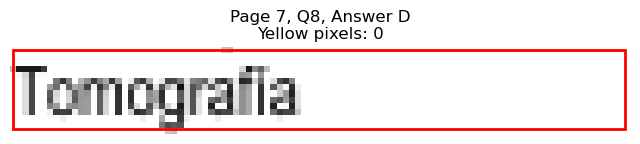


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=556.5, x1=115.0, y1=569.2
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 228
Page 7, Q9, A: Yellow percentage: 0.0%


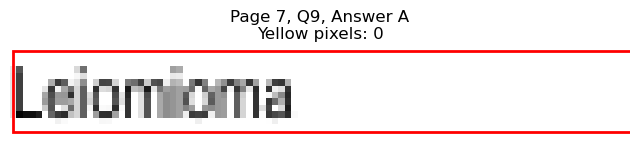

Page 7, Q9 - B: Detected box: x0=68.3, y0=569.1, x1=135.0, y1=581.8
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 364
Page 7, Q9, B: Yellow percentage: 0.0%


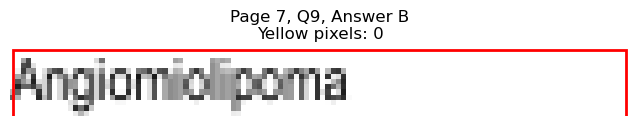

Page 7, Q9 - C: Detected box: x0=327.5, y0=556.5, x1=378.2, y1=569.2
Page 7, Q9, C: Yellow pixels: 1140
Page 7, Q9, C: Total non-white pixels: 1428
Page 7, Q9, C: Yellow percentage: 79.8%


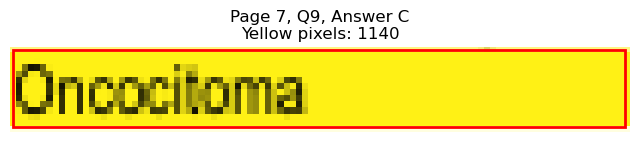

Page 7, Q9 - D: Detected box: x0=327.5, y0=569.1, x1=418.3, y1=581.8
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 583
Page 7, Q9, D: Yellow percentage: 0.0%


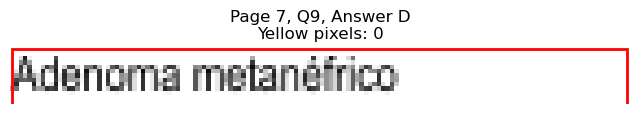


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=606.9, x1=148.6, y1=619.6
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 391
Page 7, Q10, A: Yellow percentage: 0.0%


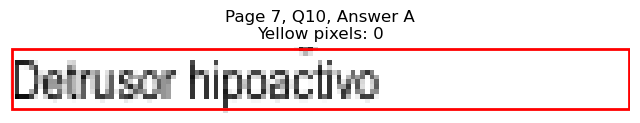

Page 7, Q10 - B: Detected box: x0=68.3, y0=619.6, x1=198.7, y1=632.3
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 703
Page 7, Q10, B: Yellow percentage: 0.0%


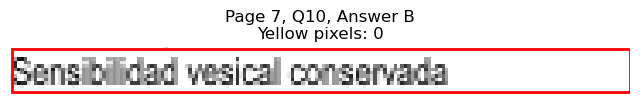

Page 7, Q10 - C: Detected box: x0=327.5, y0=606.9, x1=422.8, y1=619.6
Page 7, Q10, C: Yellow pixels: 1502
Page 7, Q10, C: Total non-white pixels: 2044
Page 7, Q10, C: Yellow percentage: 73.5%


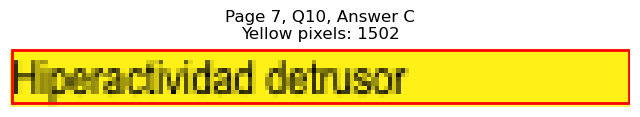

Page 7, Q10 - D: Detected box: x0=327.5, y0=619.6, x1=470.0, y1=632.3
Page 7, Q10, D: Yellow pixels: 194
Page 7, Q10, D: Total non-white pixels: 939
Page 7, Q10, D: Yellow percentage: 20.7%


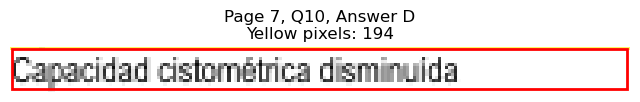


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=670.1, x1=222.3, y1=682.7
Page 7, Q11, A: Yellow pixels: 2095
Page 7, Q11, A: Total non-white pixels: 2665
Page 7, Q11, A: Yellow percentage: 78.6%


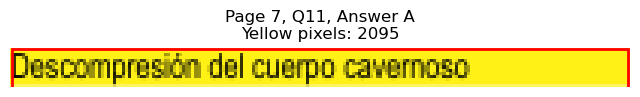

Page 7, Q11 - B: Detected box: x0=68.3, y0=682.7, x1=190.2, y1=695.3
Page 7, Q11, B: Yellow pixels: 173
Page 7, Q11, B: Total non-white pixels: 788
Page 7, Q11, B: Yellow percentage: 22.0%


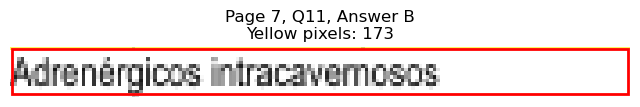

Page 7, Q11 - C: Detected box: x0=327.5, y0=670.1, x1=397.7, y1=682.7
Page 7, Q11, C: Yellow pixels: 0
Page 7, Q11, C: Total non-white pixels: 316
Page 7, Q11, C: Yellow percentage: 0.0%


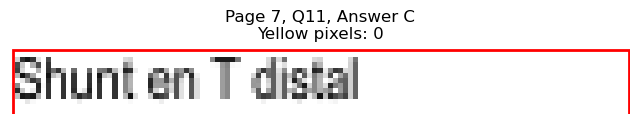

Page 7, Q11 - D: Detected box: x0=327.5, y0=682.7, x1=429.9, y1=695.3
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 517
Page 7, Q11, D: Yellow percentage: 0.0%


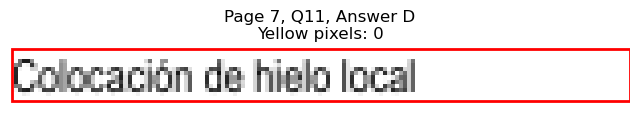


Page 7, Q11 - Selected Answer: A (based on yellow pixel count)




Page 7, Q12 - A: Detected box: x0=68.3, y0=733.2, x1=127.5, y1=745.8
Page 7, Q12, A: Yellow pixels: 1
Page 7, Q12, A: Total non-white pixels: 384
Page 7, Q12, A: Yellow percentage: 0.3%


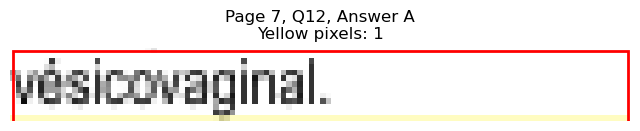

Page 7, Q12 - B: Detected box: x0=68.3, y0=745.8, x1=130.5, y1=758.4
Page 7, Q12, B: Yellow pixels: 1226
Page 7, Q12, B: Total non-white pixels: 1582
Page 7, Q12, B: Yellow percentage: 77.5%


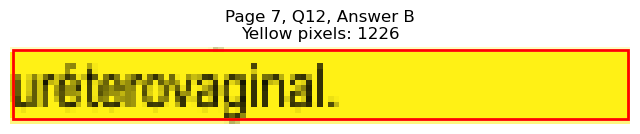

Page 7, Q12 - C: Detected box: x0=327.5, y0=733.2, x1=384.8, y1=745.8
Page 7, Q12, C: Yellow pixels: 0
Page 7, Q12, C: Total non-white pixels: 286
Page 7, Q12, C: Yellow percentage: 0.0%


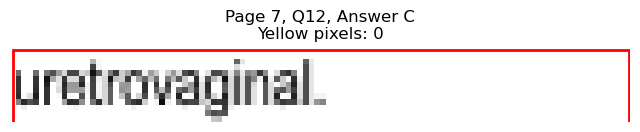

Page 7, Q12 - D: Detected box: x0=327.5, y0=745.8, x1=381.2, y1=758.4
Page 7, Q12, D: Yellow pixels: 0
Page 7, Q12, D: Total non-white pixels: 284
Page 7, Q12, D: Yellow percentage: 0.0%


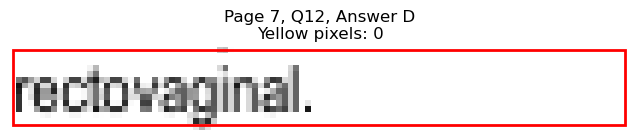


Page 7, Q12 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=105.4, y1=127.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 175
Page 8, Q1, A: Yellow percentage: 0.0%


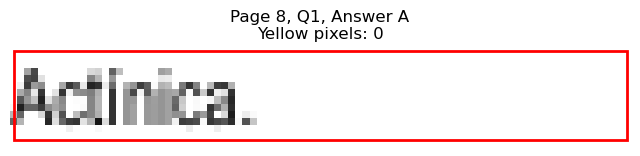

Page 8, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=124.9, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 267
Page 8, Q1, B: Yellow percentage: 0.0%


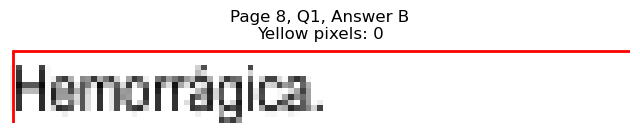

Page 8, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=363.7, y1=127.3
Page 8, Q1, C: Yellow pixels: 87
Page 8, Q1, C: Total non-white pixels: 259
Page 8, Q1, C: Yellow percentage: 33.6%


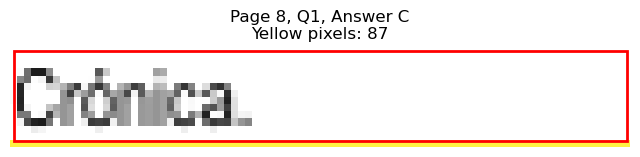

Page 8, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=370.6, y1=139.9
Page 8, Q1, D: Yellow pixels: 1037
Page 8, Q1, D: Total non-white pixels: 1222
Page 8, Q1, D: Yellow percentage: 84.9%


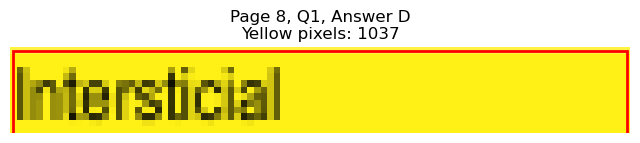


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=65.2, y1=203.0
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 61
Page 8, Q2, A: Yellow percentage: 0.0%


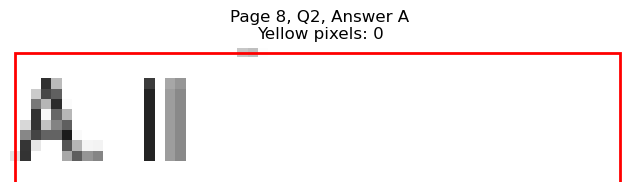

Page 8, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=65.2, y1=215.6
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 50
Page 8, Q2, B: Yellow percentage: 0.0%


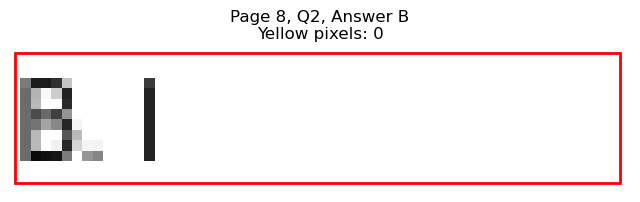

Page 8, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=337.6, y1=203.0
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 109
Page 8, Q2, C: Yellow percentage: 0.0%


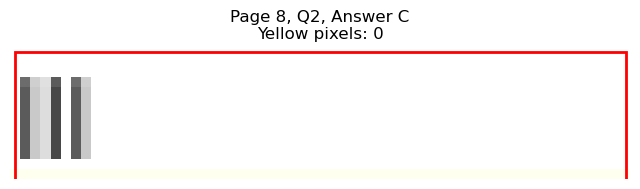

Page 8, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=340.6, y1=215.6
Page 8, Q2, D: Yellow pixels: 790
Page 8, Q2, D: Total non-white pixels: 896
Page 8, Q2, D: Yellow percentage: 88.2%


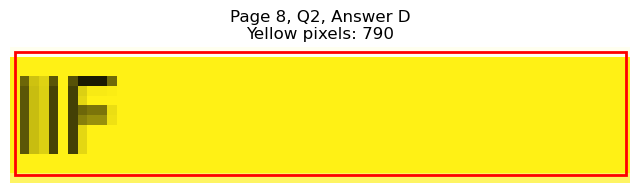


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=127.5, y1=266.1
Page 8, Q3, A: Yellow pixels: 1205
Page 8, Q3, A: Total non-white pixels: 1540
Page 8, Q3, A: Yellow percentage: 78.2%


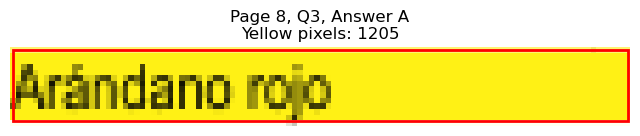

Page 8, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=125.4, y1=278.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 394
Page 8, Q3, B: Yellow percentage: 0.0%


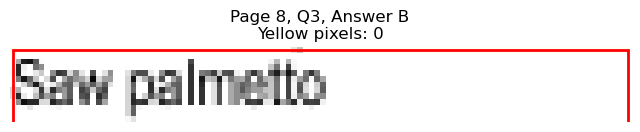

Page 8, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=402.3, y1=266.1
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 400
Page 8, Q3, C: Yellow percentage: 0.0%


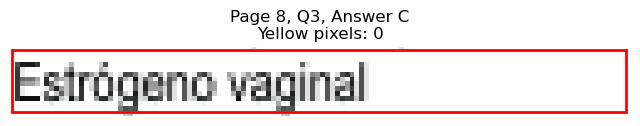

Page 8, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=374.2, y1=278.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 223
Page 8, Q3, D: Yellow percentage: 0.0%


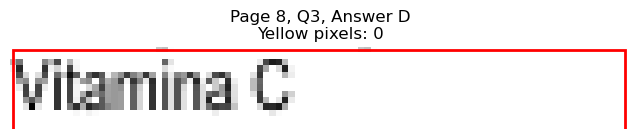


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=247.8, y1=341.9
Page 8, Q4, A: Yellow pixels: 2072
Page 8, Q4, A: Total non-white pixels: 2782
Page 8, Q4, A: Yellow percentage: 74.5%


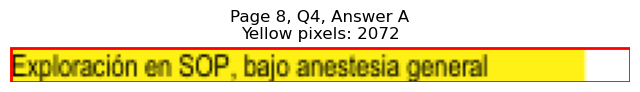

Page 8, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=192.7, y1=354.6
Page 8, Q4, B: Yellow pixels: 167
Page 8, Q4, B: Total non-white pixels: 799
Page 8, Q4, B: Yellow percentage: 20.9%


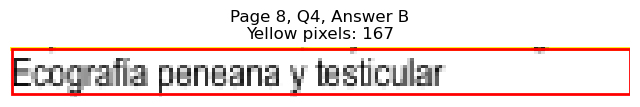

Page 8, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=442.4, y1=341.9
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 570
Page 8, Q4, C: Yellow percentage: 0.0%


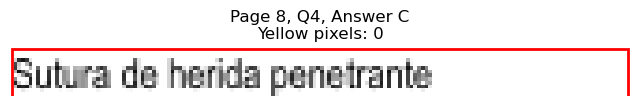

Page 8, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=380.7, y1=354.6
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 266
Page 8, Q4, D: Yellow percentage: 0.0%


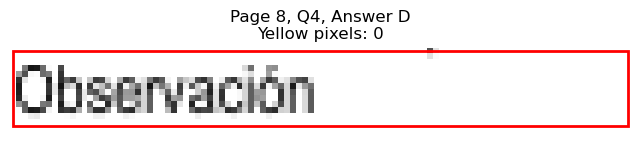


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=111.4, y1=405.0
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 330
Page 8, Q5, A: Yellow percentage: 0.0%


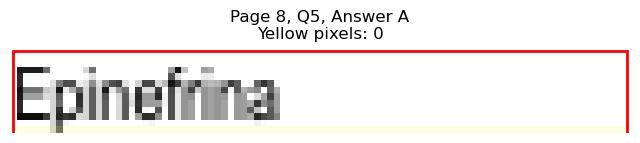

Page 8, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=112.9, y1=417.6
Page 8, Q5, B: Yellow pixels: 1056
Page 8, Q5, B: Total non-white pixels: 1330
Page 8, Q5, B: Yellow percentage: 79.4%


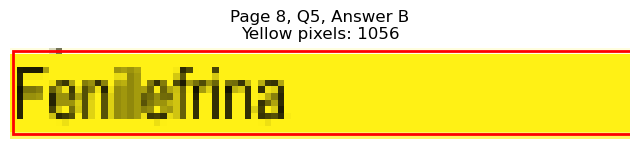

Page 8, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=363.7, y1=405.0
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 193
Page 8, Q5, C: Yellow percentage: 0.0%


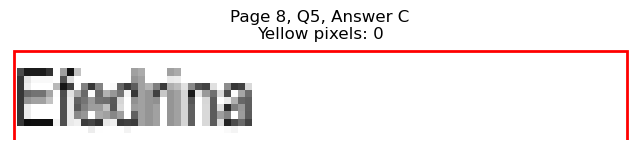

Page 8, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=365.1, y1=417.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 202
Page 8, Q5, D: Yellow percentage: 0.0%


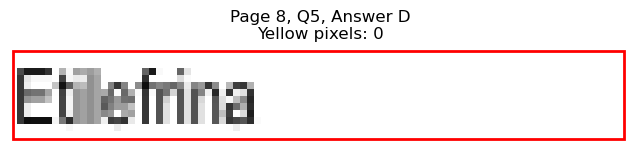


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=95.4, y1=455.5
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 161
Page 8, Q6, A: Yellow percentage: 0.0%


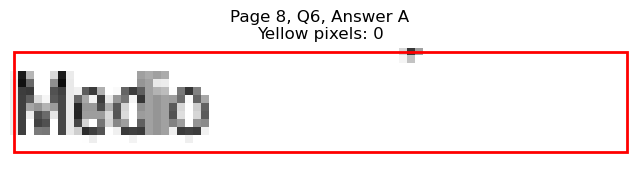

Page 8, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=104.9, y1=468.1
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 178
Page 8, Q6, B: Yellow percentage: 0.0%


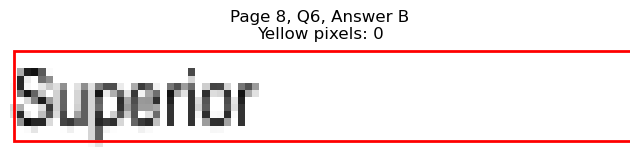

Page 8, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=370.6, y1=455.5
Page 8, Q6, C: Yellow pixels: 94
Page 8, Q6, C: Total non-white pixels: 307
Page 8, Q6, C: Yellow percentage: 30.6%


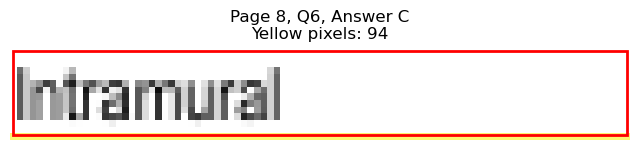

Page 8, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=352.6, y1=468.1
Page 8, Q6, D: Yellow pixels: 877
Page 8, Q6, D: Total non-white pixels: 1064
Page 8, Q6, D: Yellow percentage: 82.4%


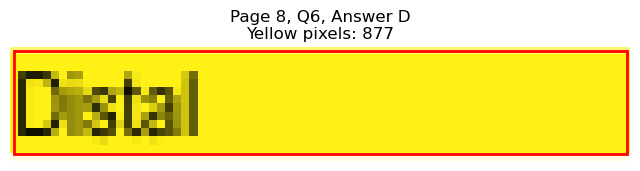


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=91.8, y1=506.0
Page 8, Q7, A: Yellow pixels: 74
Page 8, Q7, A: Total non-white pixels: 261
Page 8, Q7, A: Yellow percentage: 28.4%


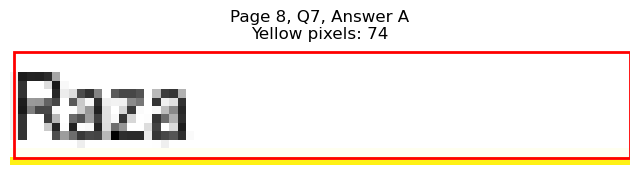

Page 8, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=91.9, y1=518.6
Page 8, Q7, B: Yellow pixels: 868
Page 8, Q7, B: Total non-white pixels: 1036
Page 8, Q7, B: Yellow percentage: 83.8%


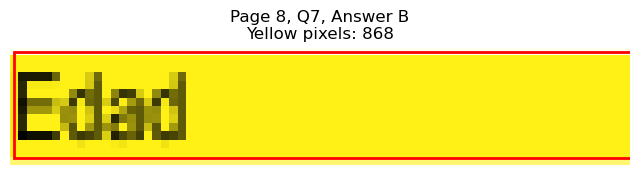

Page 8, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=361.1, y1=506.0
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 156
Page 8, Q7, C: Yellow percentage: 0.0%


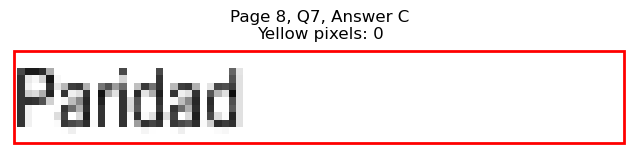

Page 8, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=368.7, y1=518.6
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 217
Page 8, Q7, D: Yellow percentage: 0.0%


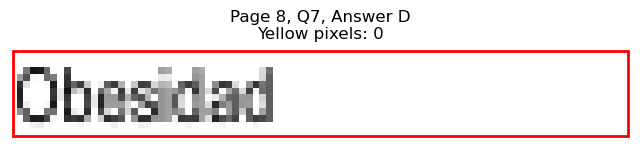


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=102.3, y1=556.4
Page 8, Q8, A: Yellow pixels: 1024
Page 8, Q8, A: Total non-white pixels: 1190
Page 8, Q8, A: Yellow percentage: 86.1%


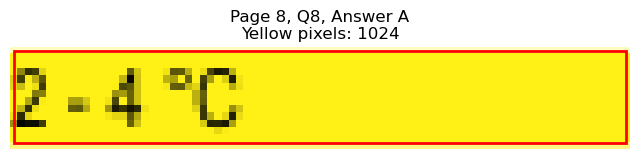

Page 8, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=102.3, y1=569.2
Page 8, Q8, B: Yellow pixels: 85
Page 8, Q8, B: Total non-white pixels: 194
Page 8, Q8, B: Yellow percentage: 43.8%


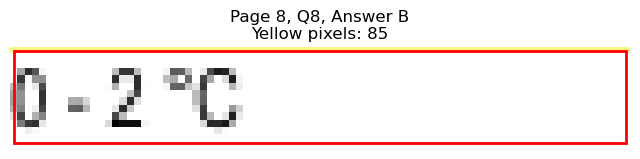

Page 8, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=361.5, y1=556.4
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 113
Page 8, Q8, C: Yellow percentage: 0.0%


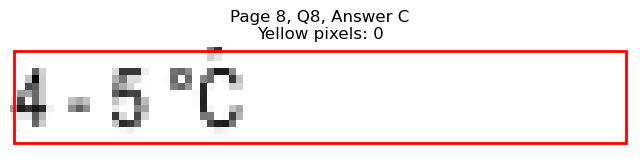

Page 8, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=361.5, y1=569.2
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 86
Page 8, Q8, D: Yellow percentage: 0.0%


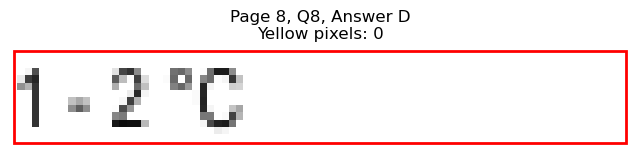


Page 8, Q8 - Selected Answer: A (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=171.6, y1=632.3
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 529
Page 8, Q9, A: Yellow percentage: 0.0%


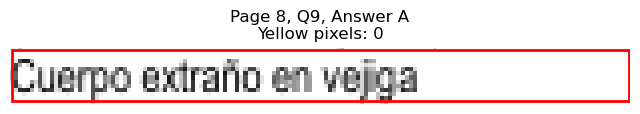

Page 8, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=157.1, y1=644.9
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 417
Page 8, Q9, B: Yellow percentage: 0.0%


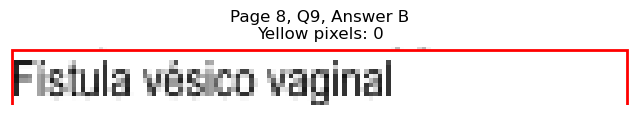

Page 8, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=414.3, y1=632.3
Page 8, Q9, C: Yellow pixels: 138
Page 8, Q9, C: Total non-white pixels: 571
Page 8, Q9, C: Yellow percentage: 24.2%


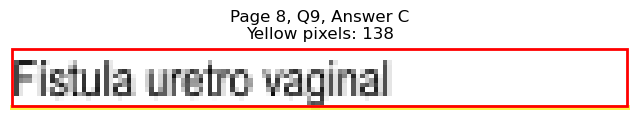

Page 8, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=440.9, y1=644.9
Page 8, Q9, D: Yellow pixels: 1721
Page 8, Q9, D: Total non-white pixels: 2132
Page 8, Q9, D: Yellow percentage: 80.7%


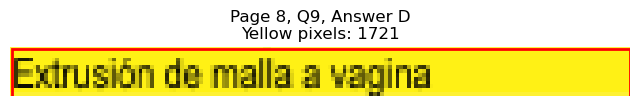


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=670.1, x1=109.9, y1=682.7
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 210
Page 8, Q10, A: Yellow percentage: 0.0%


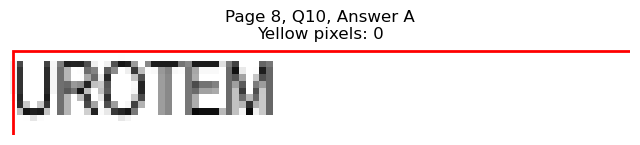

Page 8, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=117.5, y1=695.3
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 268
Page 8, Q10, B: Yellow percentage: 0.0%


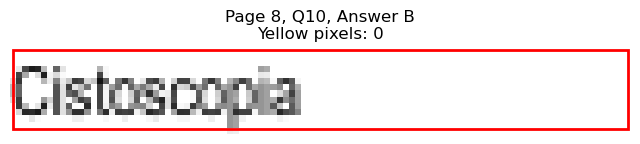

Page 8, Q10 - C: Detected box: x0=327.5, y0=670.1, x1=422.3, y1=682.7
Page 8, Q10, C: Yellow pixels: 1527
Page 8, Q10, C: Total non-white pixels: 1898
Page 8, Q10, C: Yellow percentage: 80.5%


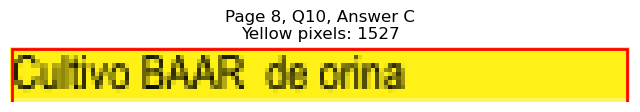

Page 8, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=371.7, y1=695.3
Page 8, Q10, D: Yellow pixels: 95
Page 8, Q10, D: Total non-white pixels: 307
Page 8, Q10, D: Yellow percentage: 30.9%


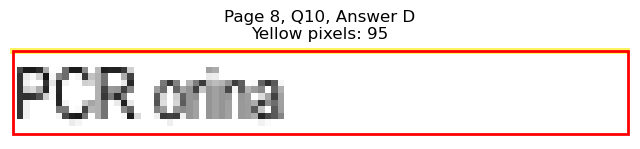


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=68.3, y0=733.2, x1=115.5, y1=745.8
Page 8, Q11, A: Yellow pixels: 0
Page 8, Q11, A: Total non-white pixels: 235
Page 8, Q11, A: Yellow percentage: 0.0%


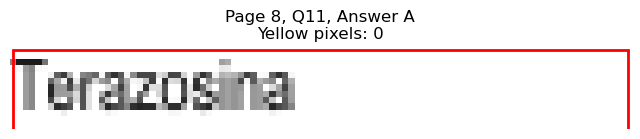

Page 8, Q11 - B: Detected box: x0=68.3, y0=745.8, x1=118.0, y1=758.4
Page 8, Q11, B: Yellow pixels: 0
Page 8, Q11, B: Total non-white pixels: 232
Page 8, Q11, B: Yellow percentage: 0.0%


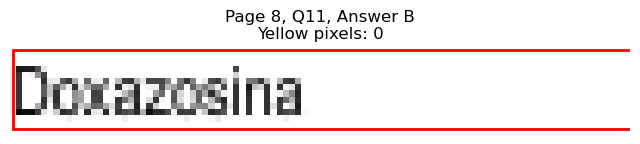

Page 8, Q11 - C: Detected box: x0=327.5, y0=733.2, x1=371.7, y1=745.8
Page 8, Q11, C: Yellow pixels: 1061
Page 8, Q11, C: Total non-white pixels: 1235
Page 8, Q11, C: Yellow percentage: 85.9%


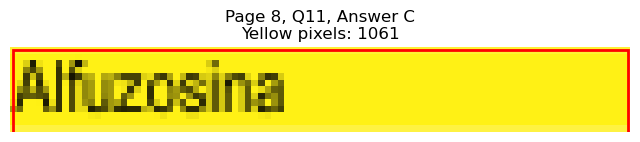

Page 8, Q11 - D: Detected box: x0=327.5, y0=745.8, x1=367.7, y1=758.4
Page 8, Q11, D: Yellow pixels: 91
Page 8, Q11, D: Total non-white pixels: 299
Page 8, Q11, D: Yellow percentage: 30.4%


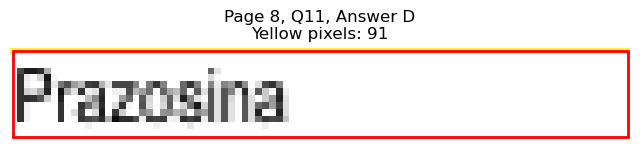


Page 8, Q11 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=286.0, y1=102.1
Page 9, Q1, A: Yellow pixels: 269
Page 9, Q1, A: Total non-white pixels: 1393
Page 9, Q1, A: Yellow percentage: 19.3%


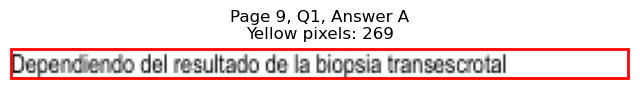

Page 9, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=207.0, y1=114.7
Page 9, Q1, B: Yellow pixels: 1995
Page 9, Q1, B: Total non-white pixels: 2470
Page 9, Q1, B: Yellow percentage: 80.8%


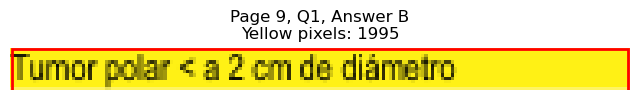

Page 9, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=249.4, y1=127.3
Page 9, Q1, C: Yellow pixels: 232
Page 9, Q1, C: Total non-white pixels: 1059
Page 9, Q1, C: Yellow percentage: 21.9%


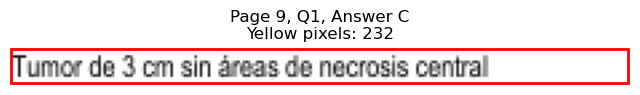

Page 9, Q1 - D: Detected box: x0=68.8, y0=127.2, x1=106.9, y1=139.9
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 190
Page 9, Q1, D: Yellow percentage: 0.0%


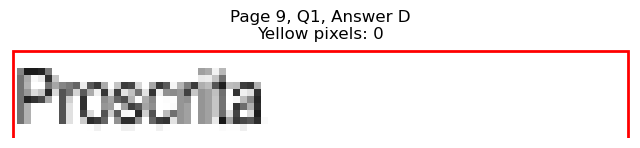


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=88.8, y1=177.8
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 79
Page 9, Q2, A: Yellow percentage: 0.0%


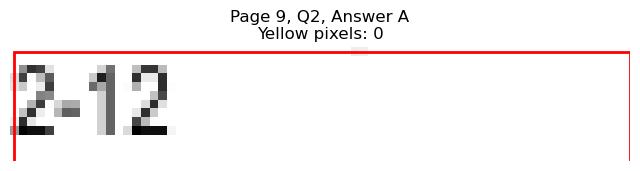

Page 9, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=88.8, y1=190.4
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 87
Page 9, Q2, B: Yellow percentage: 0.0%


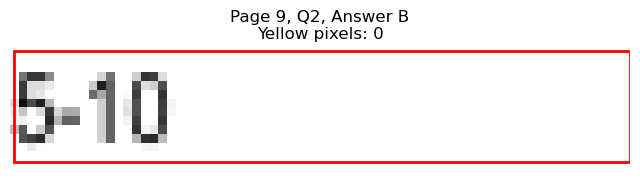

Page 9, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=353.1, y1=177.8
Page 9, Q2, C: Yellow pixels: 920
Page 9, Q2, C: Total non-white pixels: 1001
Page 9, Q2, C: Yellow percentage: 91.9%


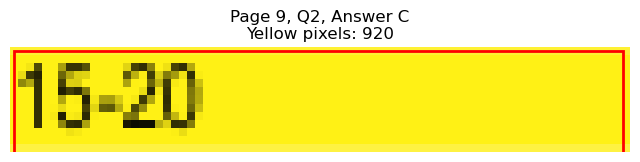

Page 9, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=348.1, y1=190.4
Page 9, Q2, D: Yellow pixels: 72
Page 9, Q2, D: Total non-white pixels: 154
Page 9, Q2, D: Yellow percentage: 46.8%


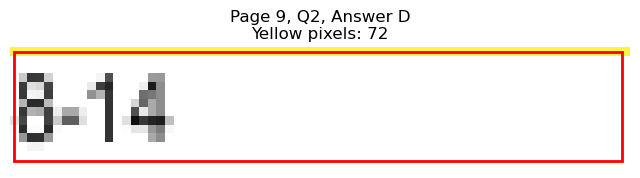


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=98.9, y1=228.3
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 97
Page 9, Q3, A: Yellow percentage: 0.0%


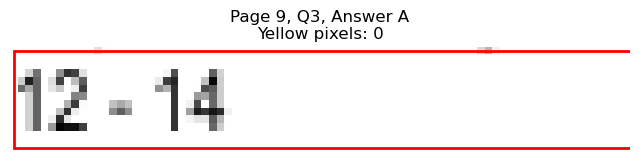

Page 9, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=93.9, y1=240.9
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 84
Page 9, Q3, B: Yellow percentage: 0.0%


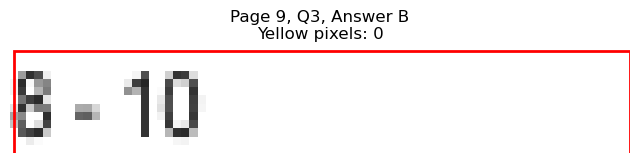

Page 9, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=358.1, y1=228.3
Page 9, Q3, C: Yellow pixels: 916
Page 9, Q3, C: Total non-white pixels: 1148
Page 9, Q3, C: Yellow percentage: 79.8%


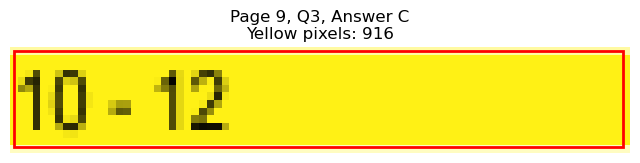

Page 9, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=355.6, y1=240.9
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 181
Page 9, Q3, D: Yellow percentage: 0.0%


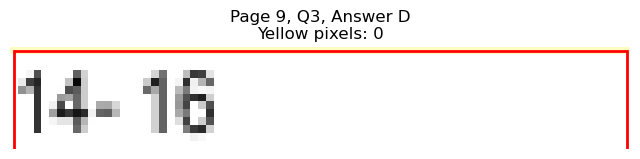


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=248.3, y1=291.5
Page 9, Q4, A: Yellow pixels: 2201
Page 9, Q4, A: Total non-white pixels: 2996
Page 9, Q4, A: Yellow percentage: 73.5%


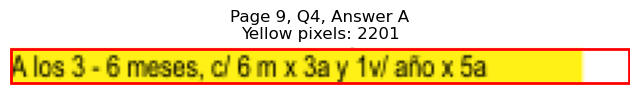

Page 9, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=193.2, y1=304.1
Page 9, Q4, B: Yellow pixels: 175
Page 9, Q4, B: Total non-white pixels: 689
Page 9, Q4, B: Yellow percentage: 25.4%


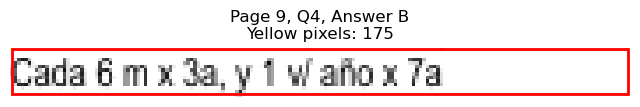

Page 9, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=452.5, y1=291.5
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 524
Page 9, Q4, C: Yellow percentage: 0.0%


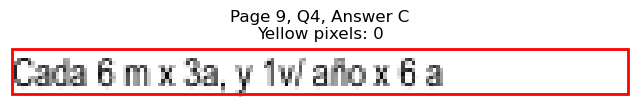

Page 9, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=393.8, y1=304.1
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 286
Page 9, Q4, D: Yellow percentage: 0.0%


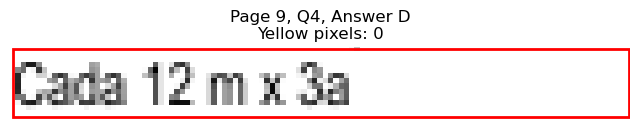


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=116.4, y1=341.9
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 258
Page 9, Q5, A: Yellow percentage: 0.0%


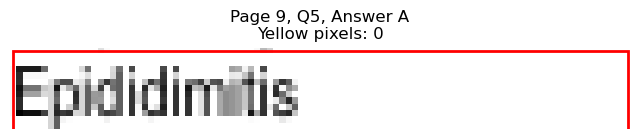

Page 9, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=139.5, y1=354.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 380
Page 9, Q5, B: Yellow percentage: 0.0%


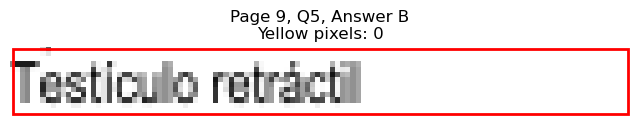

Page 9, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=372.2, y1=341.9
Page 9, Q5, C: Yellow pixels: 1086
Page 9, Q5, C: Total non-white pixels: 1248
Page 9, Q5, C: Yellow percentage: 87.0%


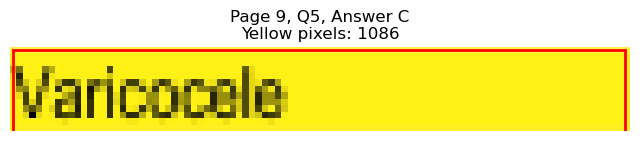

Page 9, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=368.2, y1=354.6
Page 9, Q5, D: Yellow pixels: 92
Page 9, Q5, D: Total non-white pixels: 311
Page 9, Q5, D: Yellow percentage: 29.6%


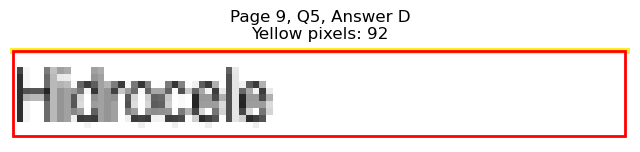


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=115.5, y1=392.4
Page 9, Q6, A: Yellow pixels: 98
Page 9, Q6, A: Total non-white pixels: 336
Page 9, Q6, A: Yellow percentage: 29.2%


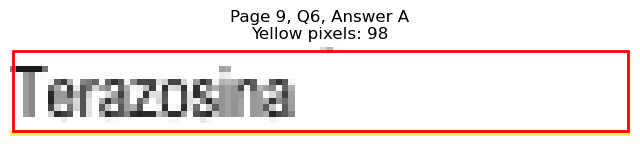

Page 9, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=121.9, y1=405.0
Page 9, Q6, B: Yellow pixels: 1146
Page 9, Q6, B: Total non-white pixels: 1352
Page 9, Q6, B: Yellow percentage: 84.8%


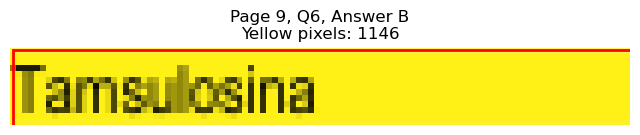

Page 9, Q6 - C: Detected box: x0=327.5, y0=379.7, x1=376.1, y1=392.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 264
Page 9, Q6, C: Yellow percentage: 0.0%


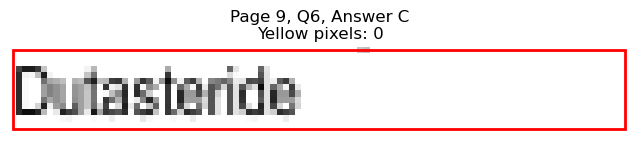

Page 9, Q6 - D: Detected box: x0=327.5, y0=392.3, x1=369.2, y1=405.0
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 223
Page 9, Q6, D: Yellow percentage: 0.0%


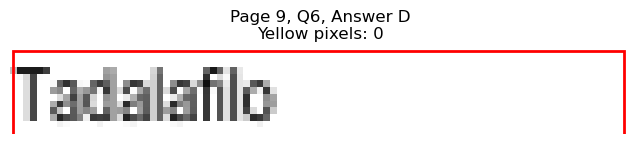


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=430.2, x1=158.1, y1=442.9
Page 9, Q7, A: Yellow pixels: 1490
Page 9, Q7, A: Total non-white pixels: 1833
Page 9, Q7, A: Yellow percentage: 81.3%


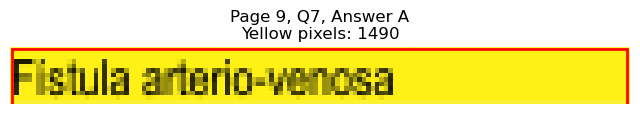

Page 9, Q7 - B: Detected box: x0=68.3, y0=442.8, x1=134.1, y1=455.5
Page 9, Q7, B: Yellow pixels: 117
Page 9, Q7, B: Total non-white pixels: 424
Page 9, Q7, B: Yellow percentage: 27.6%


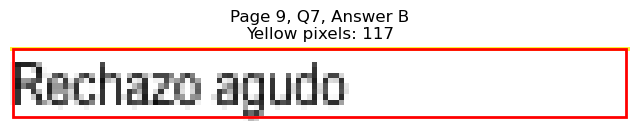

Page 9, Q7 - C: Detected box: x0=327.5, y0=430.2, x1=499.7, y1=442.9
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 859
Page 9, Q7, C: Yellow percentage: 0.0%


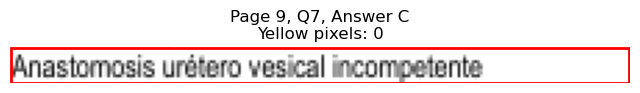

Page 9, Q7 - D: Detected box: x0=327.5, y0=442.8, x1=418.3, y1=455.5
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 481
Page 9, Q7, D: Yellow percentage: 0.0%


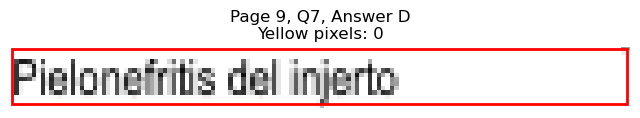


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=480.8, x1=154.1, y1=493.4
Page 9, Q8, A: Yellow pixels: 137
Page 9, Q8, A: Total non-white pixels: 565
Page 9, Q8, A: Yellow percentage: 24.2%


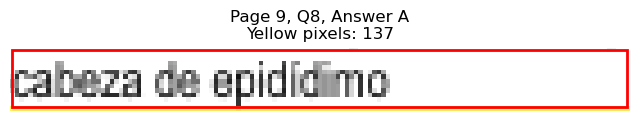

Page 9, Q8 - B: Detected box: x0=68.3, y0=493.4, x1=141.5, y1=506.0
Page 9, Q8, B: Yellow pixels: 1323
Page 9, Q8, B: Total non-white pixels: 1614
Page 9, Q8, B: Yellow percentage: 82.0%


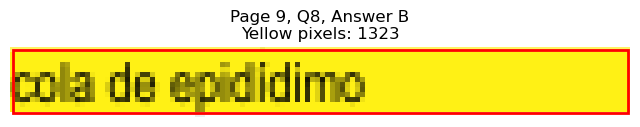

Page 9, Q8 - C: Detected box: x0=327.5, y0=480.8, x1=363.7, y1=493.4
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 185
Page 9, Q8, C: Yellow percentage: 0.0%


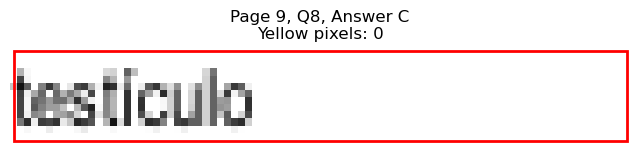

Page 9, Q8 - D: Detected box: x0=327.5, y0=493.4, x1=407.3, y1=506.0
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 412
Page 9, Q8, D: Yellow percentage: 0.0%


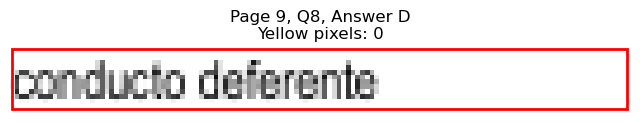


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=543.8, x1=92.4, y1=556.4
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 152
Page 9, Q9, A: Yellow percentage: 0.0%


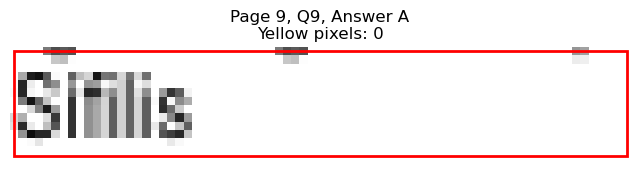

Page 9, Q9 - B: Detected box: x0=68.3, y0=556.5, x1=116.9, y1=569.2
Page 9, Q9, B: Yellow pixels: 1122
Page 9, Q9, B: Total non-white pixels: 1386
Page 9, Q9, B: Yellow percentage: 81.0%


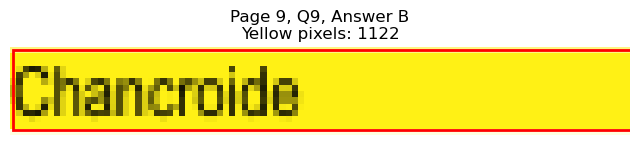

Page 9, Q9 - C: Detected box: x0=327.5, y0=543.8, x1=424.9, y1=556.4
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 487
Page 9, Q9, C: Yellow percentage: 0.0%


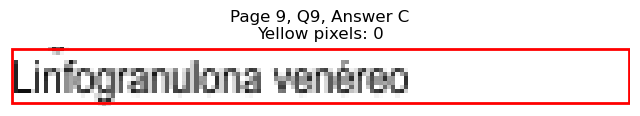

Page 9, Q9 - D: Detected box: x0=327.5, y0=556.5, x1=388.3, y1=569.2
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 329
Page 9, Q9, D: Yellow percentage: 0.0%


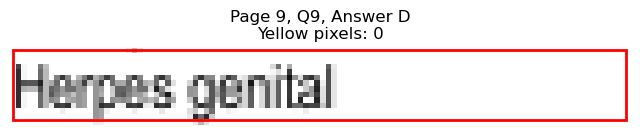


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=619.6, x1=156.6, y1=632.3
Page 9, Q10, A: Yellow pixels: 1315
Page 9, Q10, A: Total non-white pixels: 1946
Page 9, Q10, A: Yellow percentage: 67.6%


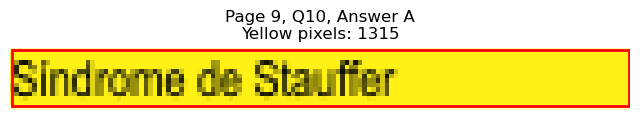

Page 9, Q10 - B: Detected box: x0=68.3, y0=632.2, x1=187.6, y1=644.9
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 763
Page 9, Q10, B: Yellow percentage: 0.0%


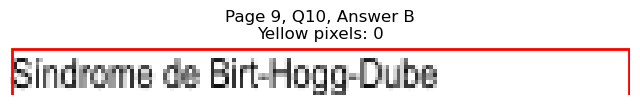

Page 9, Q10 - C: Detected box: x0=327.5, y0=619.6, x1=417.3, y1=632.3
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 448
Page 9, Q10, C: Yellow percentage: 0.0%


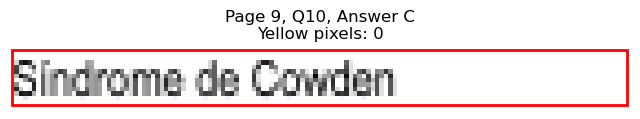

Page 9, Q10 - D: Detected box: x0=327.5, y0=632.2, x1=408.3, y1=644.9
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 393
Page 9, Q10, D: Yellow percentage: 0.0%


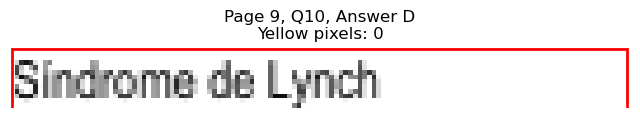


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   En la Disfunción eréctil psicógena, el compone...
1   ¿Cuál de los siguientes estudios radiológicos ...
2   En pacientes en los cuales la bacteriuria no s...
3   Mujer de 65 años que acude a consulta por pérd...
4   Mujer de 22 años. Acude por lumbalgia izquierd...
..                                                ...
95  ¿Cuál de los siguientes fármacos aumenta el ri...
96  La hematuria persistente posterior a biopsia d...
97  La maduración del espermatozoide para lograr l...
98  Varón de 30 años. Hace 7 días presenta dolor i...
99  ¿Cuál es el síndrome paraneoplásico asociado a...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0       Un inicio lento y progresivo   
1   RMN multiparamétrica de próstata   
2     Prostatitis bacteriana crónica   
3                        Cistoscopía   
4        Microembolización selectiva   
..                               ...   
95                        Terazosina   
96            Fístula arterio-venosa   
97               cabeza de epidídimo   
98                           Sífilis   
99              Síndrome de Stauffer   

                                          option_B  \
0   Asociación de catecolaminas elevadas en sangre   
1                Ecografía transrectal de próstata   
2                                              HBP   
3                                       Urodinamia   
4                        Laparoscopia exploratoria   
..                                             ...   
95                                     Tamsulosina   
96                                   Rechazo agudo   
97                               cola de epidídimo   
98                                      Chancroide   
99                      Síndrome de Birt-Hogg-Dube   

                                             option_C  \
0   Tratamiento antidepresivo con inhibidores sele...   
1                                        TC de pelvis   
2                                   Estrechez uretral   
3                       Tratamiento antiincontinencia   
4                                          Lumbotomía   
..                                                ...   
95                                        Dutasteride   
96           Anastomosis urétero vesical incompetente   
97                                          testículo   
98                             Linfogranulona venéreo   
99                                 Síndrome de Cowden   

                                   option_D  
0   El tipo de pareja que tiene el paciente  
1      Ecografía de próstata transabdominal  
2                        Estenosis de meato  
3                             Láser vaginal  
4                         Vigilancia activa  
..                                      ...  
95                               Tadalafilo  
96                Pielonefritis del injerto  
97                       conducto deferente  
98                           Herpes genital  
99                        Síndrome de Lynch  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   En la Disfunción eréctil psicógena, el compone...   
1   ¿Cuál de los siguientes estudios radiológicos ...   
2   En pacientes en los cuales la bacteriuria no s...   
3   Mujer de 65 años que acude a consulta por pérd...   
4   Mujer de 22 años. Acude por lumbalgia izquierd...   
..                                                ...   
95  ¿Cuál de los siguientes fármacos aumenta el ri...   
96  La hematuria persistente posterior a biopsia d...   
97  La maduración del espermatozoide para lograr l...   
98  Varón de 30 años. Hace 7 días presenta dolor i...   
99  ¿Cuál es el síndrome paraneoplásico asociado a...   

                            option_A  \
0       Un inicio lento y progresivo   
1   RMN multiparamétrica de próstata   
2     Prostatitis bacteriana crónica   
3                        Cistoscopía   
4        Microembolización selectiva   
..                               ...   
95                        Terazosina   
96            Fístula arterio-venosa   
97               cabeza de epidídimo   
98                           Sífilis   
99              Síndrome de Stauffer   

                                          option_B  \
0   Asociación de catecolaminas elevadas en sangre   
1                Ecografía transrectal de próstata   
2                                              HBP   
3                                       Urodinamia   
4                        Laparoscopia exploratoria   
..                                             ...   
95                                     Tamsulosina   
96                                   Rechazo agudo   
97                               cola de epidídimo   
98                                      Chancroide   
99                      Síndrome de Birt-Hogg-Dube   

                                             option_C  \
0   Tratamiento antidepresivo con inhibidores sele...   
1                                        TC de pelvis   
2                                   Estrechez uretral   
3                       Tratamiento antiincontinencia   
4                                          Lumbotomía   
..                                                ...   
95                                        Dutasteride   
96           Anastomosis urétero vesical incompetente   
97                                          testículo   
98                             Linfogranulona venéreo   
99                                 Síndrome de Cowden   

                                   option_D correct_answer  
0   El tipo de pareja que tiene el paciente              B  
1      Ecografía de próstata transabdominal              B  
2                        Estenosis de meato              A  
3                             Láser vaginal              A  
4                         Vigilancia activa              D  
..                                      ...            ...  
95                               Tadalafilo              B  
96                Pielonefritis del injerto              A  
97                       conducto deferente              B  
98                           Herpes genital              B  
99                        Síndrome de Lynch              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/UROLOGÍA.csv
